In [1]:
from sklearn.preprocessing import normalize
import numpy as np
import random
x=random.random()
print(x)
import sys
#!{sys.executable} -m pip install torch 

0.09004436256590775


In [2]:
#!{sys.executable} -m pip install gym
#!{sys.executable} -m pip install sklearn 
#!{sys.executable} -m pip install seaborn
import os
import torch
import random
import numpy as np
from collections import namedtuple, deque 
import math
import gym
from gym import logger,spaces
from sklearn import preprocessing
import matplotlib.pyplot as plt

from UAV_ENV.envs.DQNenv import DQNUAVenv
from DQN_PyTorch import dqn_agent
#from DQN import DQNagent
#import seaborn as sns 
from mpl_toolkits import mplot3d

/home/joaquin/.local/lib/python3.6/site-packages/gym/core.py:27: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"


In [3]:
# registering the created environment in OpenAI gym : https://www.youtube.com/watch?v=kd4RrN-FTWY
# creating an environment object
#env=DQNUAVenv()
env= gym.make('DqnUavEnv-v0')
env.seed(0)
Observations=env.observation_space.shape[0]
#Observations_n=env.observation_space.n
Observation_shape=env.observation_space.shape
state=env.reset()
Actions_shape=env.action_space
Actions=env.action_space.n
print('Observation_space:',Observations)
#print('Observation_number:',Observations_n)
print('Observation_shape:',Observation_shape)
print('Action_space:',Actions_shape)
print('Action_number:', Actions)
print('Initial_state: ',state)
#env.path_plot()

Observation_space: 9
Observation_shape: (9,)
Action_space: Discrete(48)
Action_number: 48
Initial_state:  [ 20  40 100 147 217   1 167 203   1]


/home/joaquin/.local/lib/python3.6/site-packages/gym/envs/registration.py:556: UserWarning: WARN: The environment DqnUavEnv-v0 is out of date. You should consider upgrading to version `v3`.
  f"The environment {id} is out of date. You should consider "
/home/joaquin/.local/lib/python3.6/site-packages/gym/utils/passive_env_checker.py:196: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  f"The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `{type(result)}`"


In [4]:
# creating DQN agent
seed=0
Agent_DQN=dqn_agent(Observations,Actions,seed=0)
# creating DDPG agent
#Agent_DDPG=ddpg_agent(Observation_n,Action_dim)  # create environment object before calling

Input of net is:  9
Action size is:  48
Input of net is:  9
Action size is:  48


In [6]:
# training the dqn agent
num_episode=25000
step_per_episode=200

reward_per_episode=[]
Avg_reward_per_episode=[]
Avg_energy_per_episode=[]
Energy_per_episode=[]
Avg_Rate_per_episode=[]
losses_per_episode=[]
Avg_energy_training=[]

exploration_rate=1
# before it was 0.995
epsilon_decay=0.9998
Min_epsilon=0.01

# saving all location in a array
x_location=[]
y_location=[]
z_location=[]

for i in range (num_episode):
    # reset environment
    state=env.reset()
    #print("state is:" ,state)
    cum_reward=0
    Avg_reward=[]
    Avg_rate=[]
    Avg_energy=[]
    losses=0
    done=False
    #epsilon=Max_epsilon
    
    for j in range (step_per_episode-1):
        #print("state is:" ,state)
        
        # action selection
        action=Agent_DQN.choose_action(state,exploration_rate)
        #print("Action is: ",action)
        
        # calculate reward for chosen action
        next_state,reward,done,Data_Rate=env.step(action)
        #print(reward)
        # save transition 
        loss=Agent_DQN.reply_buffer(state,action,reward,next_state,done)
        # sampling for agent training
        #loss=Agent_DQN.sample_buffer()
        if loss is not None:
            losses+=loss
        
        energy_per_step,sum_energy=env.energy(state,next_state[0:3])
        
        #print("reward,next_state,done,energy: ",reward,next_state,done,energy_per_step)
        #print('========================')
        
        state=next_state
        cum_reward+=reward
        Avg_reward.append(reward)
        Avg_rate.append(Data_Rate["Rate"])
        Avg_energy.append(energy_per_step)
        #energy+=energy_per_step
        
        if i==num_episode-1:
            x_location.append(next_state[0])
            y_location.append(next_state[1])
            z_location.append(next_state[2])
         
        if done:
            break

    exploration_rate *= epsilon_decay
    exploration_rate= max(exploration_rate,Min_epsilon)
        
    # average reward calculation
    losses_per_episode.append(losses)
    reward_per_episode.append(cum_reward)
    Avg_reward_per_episode.append(np.mean(Avg_reward))
    Avg_Rate_per_episode.append(np.mean(Avg_rate))
    Avg_energy_per_episode.append(np.mean(Avg_energy))
    
    Energy_per_episode.append(sum_energy)
    Avg_energy_training.append(np.mean(Energy_per_episode))
    

    
    # print the training results
    if (i%2==0):
        print('\rEpisode {} \t Reward: {:.2f},\t Loss: {:.2f}, \t Energy:{:.2f}'.
              format(i, reward_per_episode[i],losses_per_episode[i],Energy_per_episode[i]))
                                                                                         
        #print('\rEpisode {}\tloss: {:.2f}'.format(i, losses[i]))

    # save parameters of main network 
    if i==num_episode-1:
        # create a file to save weights and bias
        FILE="model_parameters.pth"
        torch.save(Agent_DQN.main_network.state_dict(),FILE)



Episode 0 	 Reward: 16.91,	 Loss: 15.35, 	 Energy:40.38
Episode 2 	 Reward: 22.84,	 Loss: 15.77, 	 Energy:34.53
Episode 4 	 Reward: 6.23,	 Loss: 17.69, 	 Energy:44.87
Episode 6 	 Reward: 22.18,	 Loss: 22.73, 	 Energy:35.28
Episode 8 	 Reward: 6.98,	 Loss: 25.14, 	 Energy:28.70
Episode 10 	 Reward: 7.35,	 Loss: 21.03, 	 Energy:22.29
Episode 12 	 Reward: 17.83,	 Loss: 20.77, 	 Energy:33.46
Episode 14 	 Reward: 37.78,	 Loss: 13.40, 	 Energy:21.99
Episode 16 	 Reward: 14.02,	 Loss: 17.85, 	 Energy:31.47
Episode 18 	 Reward: 5.48,	 Loss: 15.50, 	 Energy:33.56
Episode 20 	 Reward: 27.39,	 Loss: 15.70, 	 Energy:40.12
Episode 22 	 Reward: 15.66,	 Loss: 16.92, 	 Energy:30.30
Episode 24 	 Reward: 17.54,	 Loss: 18.62, 	 Energy:29.26
Episode 26 	 Reward: 25.02,	 Loss: 10.81, 	 Energy:27.20
Episode 28 	 Reward: 16.30,	 Loss: 14.61, 	 Energy:48.09
Episode 30 	 Reward: 18.72,	 Loss: 25.82, 	 Energy:26.45
Episode 32 	 Reward: 43.77,	 Loss: 18.86, 	 Energy:34.02
Episode 34 	 Reward: 40.67,	 Loss: 18.36

Episode 286 	 Reward: 29.33,	 Loss: 5.38, 	 Energy:19.60
Episode 288 	 Reward: 33.99,	 Loss: 17.29, 	 Energy:26.44
Episode 290 	 Reward: 13.82,	 Loss: 3.35, 	 Energy:11.14
Episode 292 	 Reward: 36.67,	 Loss: 8.98, 	 Energy:28.50
Episode 294 	 Reward: 19.73,	 Loss: 8.55, 	 Energy:39.95
Episode 296 	 Reward: 23.29,	 Loss: 10.55, 	 Energy:26.77
Episode 298 	 Reward: 26.96,	 Loss: 10.78, 	 Energy:26.22
Episode 300 	 Reward: 35.45,	 Loss: 14.05, 	 Energy:34.14
Episode 302 	 Reward: 45.19,	 Loss: 14.15, 	 Energy:20.52
Episode 304 	 Reward: 22.03,	 Loss: 11.10, 	 Energy:29.04
Episode 306 	 Reward: 13.25,	 Loss: 11.68, 	 Energy:22.49
Episode 308 	 Reward: 9.72,	 Loss: 4.32, 	 Energy:13.69
Episode 310 	 Reward: 17.47,	 Loss: 9.88, 	 Energy:27.92
Episode 312 	 Reward: 33.72,	 Loss: 11.12, 	 Energy:22.98
Episode 314 	 Reward: 23.65,	 Loss: 9.11, 	 Energy:23.49
Episode 316 	 Reward: 30.85,	 Loss: 13.61, 	 Energy:27.66
Episode 318 	 Reward: 39.89,	 Loss: 11.98, 	 Energy:23.10
Episode 320 	 Reward: 

Episode 570 	 Reward: 42.89,	 Loss: 8.02, 	 Energy:23.00
Episode 572 	 Reward: 39.58,	 Loss: 12.98, 	 Energy:26.98
Episode 574 	 Reward: 31.67,	 Loss: 10.28, 	 Energy:38.21
Episode 576 	 Reward: 14.82,	 Loss: 14.16, 	 Energy:24.81
Episode 578 	 Reward: 34.90,	 Loss: 14.47, 	 Energy:25.43
Episode 580 	 Reward: 35.32,	 Loss: 13.49, 	 Energy:23.58
Episode 582 	 Reward: 24.24,	 Loss: 6.02, 	 Energy:18.61
Episode 584 	 Reward: 36.31,	 Loss: 11.26, 	 Energy:24.30
Episode 586 	 Reward: 37.82,	 Loss: 10.62, 	 Energy:26.44
Episode 588 	 Reward: 18.92,	 Loss: 9.54, 	 Energy:23.54
Episode 590 	 Reward: 33.83,	 Loss: 13.27, 	 Energy:40.95
Episode 592 	 Reward: 25.16,	 Loss: 14.49, 	 Energy:33.99
Episode 594 	 Reward: 36.30,	 Loss: 8.45, 	 Energy:16.11
Episode 596 	 Reward: 48.19,	 Loss: 12.26, 	 Energy:22.21
Episode 598 	 Reward: 25.41,	 Loss: 5.61, 	 Energy:10.09
Episode 600 	 Reward: 24.99,	 Loss: 12.95, 	 Energy:25.67
Episode 602 	 Reward: 22.15,	 Loss: 15.68, 	 Energy:28.53
Episode 604 	 Rewar

Episode 854 	 Reward: 50.20,	 Loss: 11.84, 	 Energy:27.89
Episode 856 	 Reward: 36.29,	 Loss: 9.99, 	 Energy:26.36
Episode 858 	 Reward: 61.02,	 Loss: 10.06, 	 Energy:25.60
Episode 860 	 Reward: 48.28,	 Loss: 12.57, 	 Energy:26.22
Episode 862 	 Reward: 67.68,	 Loss: 11.08, 	 Energy:20.05
Episode 864 	 Reward: 35.57,	 Loss: 11.56, 	 Energy:24.37
Episode 866 	 Reward: 20.40,	 Loss: 10.79, 	 Energy:29.98
Episode 868 	 Reward: 67.98,	 Loss: 11.72, 	 Energy:34.71
Episode 870 	 Reward: 33.75,	 Loss: 12.73, 	 Energy:25.07
Episode 872 	 Reward: 45.68,	 Loss: 10.72, 	 Energy:23.59
Episode 874 	 Reward: 27.02,	 Loss: 6.00, 	 Energy:14.88
Episode 876 	 Reward: 43.50,	 Loss: 8.38, 	 Energy:25.15
Episode 878 	 Reward: 43.70,	 Loss: 8.94, 	 Energy:32.39
Episode 880 	 Reward: 29.92,	 Loss: 7.63, 	 Energy:18.48
Episode 882 	 Reward: 22.64,	 Loss: 10.64, 	 Energy:33.49
Episode 884 	 Reward: 26.38,	 Loss: 12.32, 	 Energy:22.94
Episode 886 	 Reward: 28.30,	 Loss: 6.28, 	 Energy:18.38
Episode 888 	 Reward

Episode 1138 	 Reward: 41.74,	 Loss: 11.70, 	 Energy:23.73
Episode 1140 	 Reward: 50.57,	 Loss: 9.94, 	 Energy:27.23
Episode 1142 	 Reward: 70.51,	 Loss: 10.33, 	 Energy:25.10
Episode 1144 	 Reward: 57.28,	 Loss: 10.16, 	 Energy:33.95
Episode 1146 	 Reward: 66.36,	 Loss: 11.23, 	 Energy:26.97
Episode 1148 	 Reward: 60.36,	 Loss: 10.28, 	 Energy:24.89
Episode 1150 	 Reward: 83.33,	 Loss: 11.62, 	 Energy:35.47
Episode 1152 	 Reward: 32.63,	 Loss: 6.68, 	 Energy:11.75
Episode 1154 	 Reward: 48.06,	 Loss: 11.20, 	 Energy:23.24
Episode 1156 	 Reward: 48.32,	 Loss: 10.74, 	 Energy:29.26
Episode 1158 	 Reward: 39.61,	 Loss: 8.32, 	 Energy:25.24
Episode 1160 	 Reward: 63.08,	 Loss: 9.29, 	 Energy:22.17
Episode 1162 	 Reward: 24.06,	 Loss: 2.79, 	 Energy:8.79
Episode 1164 	 Reward: 50.82,	 Loss: 9.54, 	 Energy:29.87
Episode 1166 	 Reward: 78.56,	 Loss: 7.98, 	 Energy:20.15
Episode 1168 	 Reward: 62.84,	 Loss: 11.31, 	 Energy:25.09
Episode 1170 	 Reward: 73.02,	 Loss: 11.06, 	 Energy:24.84
Episo

Episode 1420 	 Reward: 60.46,	 Loss: 8.65, 	 Energy:17.48
Episode 1422 	 Reward: 39.52,	 Loss: 7.68, 	 Energy:23.40
Episode 1424 	 Reward: 37.36,	 Loss: 9.67, 	 Energy:29.36
Episode 1426 	 Reward: 73.14,	 Loss: 8.45, 	 Energy:17.15
Episode 1428 	 Reward: 80.48,	 Loss: 11.04, 	 Energy:17.34
Episode 1430 	 Reward: 59.31,	 Loss: 10.93, 	 Energy:24.98
Episode 1432 	 Reward: 30.22,	 Loss: 3.75, 	 Energy:11.67
Episode 1434 	 Reward: 20.28,	 Loss: 8.16, 	 Energy:34.86
Episode 1436 	 Reward: 26.27,	 Loss: 3.16, 	 Energy:12.62
Episode 1438 	 Reward: 31.38,	 Loss: 3.73, 	 Energy:8.23
Episode 1440 	 Reward: 14.21,	 Loss: 2.54, 	 Energy:10.66
Episode 1442 	 Reward: 29.32,	 Loss: 9.25, 	 Energy:22.03
Episode 1444 	 Reward: 37.59,	 Loss: 7.84, 	 Energy:22.21
Episode 1446 	 Reward: 92.07,	 Loss: 8.82, 	 Energy:21.27
Episode 1448 	 Reward: 81.45,	 Loss: 11.55, 	 Energy:20.07
Episode 1450 	 Reward: 52.86,	 Loss: 10.88, 	 Energy:15.42
Episode 1452 	 Reward: 35.92,	 Loss: 8.94, 	 Energy:22.68
Episode 145

Episode 1704 	 Reward: 39.87,	 Loss: 8.23, 	 Energy:24.96
Episode 1706 	 Reward: 18.69,	 Loss: 8.56, 	 Energy:23.11
Episode 1708 	 Reward: 44.69,	 Loss: 8.37, 	 Energy:23.62
Episode 1710 	 Reward: 67.27,	 Loss: 8.60, 	 Energy:28.23
Episode 1712 	 Reward: 52.54,	 Loss: 9.16, 	 Energy:23.00
Episode 1714 	 Reward: 50.18,	 Loss: 5.68, 	 Energy:12.73
Episode 1716 	 Reward: 66.61,	 Loss: 5.71, 	 Energy:14.77
Episode 1718 	 Reward: 54.60,	 Loss: 4.51, 	 Energy:10.69
Episode 1720 	 Reward: 36.78,	 Loss: 4.32, 	 Energy:14.50
Episode 1722 	 Reward: 21.36,	 Loss: 7.44, 	 Energy:38.25
Episode 1724 	 Reward: 14.40,	 Loss: 6.86, 	 Energy:49.52
Episode 1726 	 Reward: 54.30,	 Loss: 5.68, 	 Energy:19.13
Episode 1728 	 Reward: 68.33,	 Loss: 8.16, 	 Energy:21.48
Episode 1730 	 Reward: 71.57,	 Loss: 6.25, 	 Energy:14.11
Episode 1732 	 Reward: 30.29,	 Loss: 3.11, 	 Energy:9.04
Episode 1734 	 Reward: 49.14,	 Loss: 7.92, 	 Energy:20.87
Episode 1736 	 Reward: 66.73,	 Loss: 6.08, 	 Energy:16.79
Episode 1738 	 

Episode 1988 	 Reward: 62.71,	 Loss: 7.17, 	 Energy:18.85
Episode 1990 	 Reward: 59.01,	 Loss: 6.01, 	 Energy:20.51
Episode 1992 	 Reward: 48.26,	 Loss: 4.38, 	 Energy:12.05
Episode 1994 	 Reward: 73.60,	 Loss: 5.64, 	 Energy:17.11
Episode 1996 	 Reward: 21.05,	 Loss: 1.79, 	 Energy:7.87
Episode 1998 	 Reward: 27.58,	 Loss: 1.87, 	 Energy:7.82
Episode 2000 	 Reward: 42.57,	 Loss: 6.08, 	 Energy:19.94
Episode 2002 	 Reward: 66.21,	 Loss: 3.69, 	 Energy:14.54
Episode 2004 	 Reward: 93.19,	 Loss: 7.68, 	 Energy:18.42
Episode 2006 	 Reward: 76.06,	 Loss: 7.78, 	 Energy:27.74
Episode 2008 	 Reward: 71.11,	 Loss: 4.60, 	 Energy:14.96
Episode 2010 	 Reward: 56.12,	 Loss: 2.85, 	 Energy:7.45
Episode 2012 	 Reward: 59.03,	 Loss: 6.62, 	 Energy:17.29
Episode 2014 	 Reward: 101.93,	 Loss: 7.22, 	 Energy:22.12
Episode 2016 	 Reward: 46.70,	 Loss: 3.75, 	 Energy:15.31
Episode 2018 	 Reward: 50.54,	 Loss: 2.37, 	 Energy:5.60
Episode 2020 	 Reward: 68.97,	 Loss: 3.58, 	 Energy:14.89
Episode 2022 	 Re

Episode 2272 	 Reward: 110.57,	 Loss: 7.46, 	 Energy:16.49
Episode 2274 	 Reward: 103.68,	 Loss: 7.60, 	 Energy:17.23
Episode 2276 	 Reward: 82.90,	 Loss: 6.26, 	 Energy:15.70
Episode 2278 	 Reward: 50.97,	 Loss: 3.45, 	 Energy:9.89
Episode 2280 	 Reward: 84.61,	 Loss: 5.87, 	 Energy:16.73
Episode 2282 	 Reward: 90.22,	 Loss: 6.64, 	 Energy:29.11
Episode 2284 	 Reward: 77.22,	 Loss: 4.12, 	 Energy:12.32
Episode 2286 	 Reward: 50.75,	 Loss: 2.21, 	 Energy:7.37
Episode 2288 	 Reward: 52.39,	 Loss: 2.96, 	 Energy:7.39
Episode 2290 	 Reward: 21.34,	 Loss: 2.11, 	 Energy:6.15
Episode 2292 	 Reward: 20.57,	 Loss: 1.22, 	 Energy:4.65
Episode 2294 	 Reward: 72.64,	 Loss: 6.10, 	 Energy:20.79
Episode 2296 	 Reward: 28.01,	 Loss: 2.06, 	 Energy:8.37
Episode 2298 	 Reward: 32.76,	 Loss: 2.99, 	 Energy:9.29
Episode 2300 	 Reward: 53.72,	 Loss: 3.52, 	 Energy:10.77
Episode 2302 	 Reward: 60.38,	 Loss: 4.69, 	 Energy:21.43
Episode 2304 	 Reward: 33.39,	 Loss: 2.21, 	 Energy:7.42
Episode 2306 	 Rewar

Episode 2556 	 Reward: 31.01,	 Loss: 1.64, 	 Energy:4.59
Episode 2558 	 Reward: 48.80,	 Loss: 4.10, 	 Energy:16.10
Episode 2560 	 Reward: 25.37,	 Loss: 1.95, 	 Energy:4.45
Episode 2562 	 Reward: 95.62,	 Loss: 7.59, 	 Energy:21.75
Episode 2564 	 Reward: 24.51,	 Loss: 3.28, 	 Energy:12.51
Episode 2566 	 Reward: 22.75,	 Loss: 2.05, 	 Energy:8.20
Episode 2568 	 Reward: 59.08,	 Loss: 4.77, 	 Energy:18.48
Episode 2570 	 Reward: 21.43,	 Loss: 1.56, 	 Energy:3.82
Episode 2572 	 Reward: 88.59,	 Loss: 7.56, 	 Energy:25.32
Episode 2574 	 Reward: 29.93,	 Loss: 3.29, 	 Energy:8.42
Episode 2576 	 Reward: 91.54,	 Loss: 6.54, 	 Energy:23.66
Episode 2578 	 Reward: 57.53,	 Loss: 3.38, 	 Energy:9.70
Episode 2580 	 Reward: 89.57,	 Loss: 7.99, 	 Energy:32.40
Episode 2582 	 Reward: 105.06,	 Loss: 6.37, 	 Energy:16.53
Episode 2584 	 Reward: 53.24,	 Loss: 3.45, 	 Energy:9.51
Episode 2586 	 Reward: 13.16,	 Loss: 1.25, 	 Energy:6.55
Episode 2588 	 Reward: 102.20,	 Loss: 7.01, 	 Energy:25.18
Episode 2590 	 Rewar

Episode 2840 	 Reward: 89.05,	 Loss: 5.91, 	 Energy:24.18
Episode 2842 	 Reward: 78.14,	 Loss: 7.92, 	 Energy:28.42
Episode 2844 	 Reward: 65.60,	 Loss: 5.91, 	 Energy:23.71
Episode 2846 	 Reward: 23.45,	 Loss: 2.20, 	 Energy:11.14
Episode 2848 	 Reward: 20.12,	 Loss: 1.94, 	 Energy:6.78
Episode 2850 	 Reward: 59.78,	 Loss: 5.26, 	 Energy:26.49
Episode 2852 	 Reward: 92.12,	 Loss: 8.60, 	 Energy:29.15
Episode 2854 	 Reward: 17.43,	 Loss: 1.70, 	 Energy:8.42
Episode 2856 	 Reward: 80.45,	 Loss: 7.92, 	 Energy:17.98
Episode 2858 	 Reward: 93.70,	 Loss: 6.38, 	 Energy:16.90
Episode 2860 	 Reward: 88.39,	 Loss: 5.09, 	 Energy:21.27
Episode 2862 	 Reward: 56.58,	 Loss: 8.24, 	 Energy:42.87
Episode 2864 	 Reward: 40.68,	 Loss: 3.00, 	 Energy:10.47
Episode 2866 	 Reward: 52.10,	 Loss: 3.28, 	 Energy:7.71
Episode 2868 	 Reward: 16.61,	 Loss: 1.90, 	 Energy:8.49
Episode 2870 	 Reward: 71.19,	 Loss: 5.78, 	 Energy:17.80
Episode 2872 	 Reward: 41.42,	 Loss: 3.27, 	 Energy:11.66
Episode 2874 	 Rew

Episode 3124 	 Reward: 34.94,	 Loss: 2.96, 	 Energy:14.78
Episode 3126 	 Reward: 46.99,	 Loss: 4.03, 	 Energy:8.48
Episode 3128 	 Reward: 51.00,	 Loss: 3.47, 	 Energy:15.78
Episode 3130 	 Reward: 29.05,	 Loss: 2.53, 	 Energy:4.95
Episode 3132 	 Reward: 69.31,	 Loss: 4.96, 	 Energy:16.65
Episode 3134 	 Reward: 100.17,	 Loss: 8.52, 	 Energy:24.99
Episode 3136 	 Reward: 21.81,	 Loss: 2.05, 	 Energy:5.22
Episode 3138 	 Reward: 25.19,	 Loss: 2.19, 	 Energy:6.75
Episode 3140 	 Reward: 40.21,	 Loss: 3.09, 	 Energy:11.18
Episode 3142 	 Reward: 36.87,	 Loss: 2.04, 	 Energy:9.45
Episode 3144 	 Reward: 20.74,	 Loss: 1.56, 	 Energy:6.98
Episode 3146 	 Reward: 72.08,	 Loss: 5.14, 	 Energy:17.25
Episode 3148 	 Reward: 58.77,	 Loss: 3.10, 	 Energy:6.89
Episode 3150 	 Reward: 67.12,	 Loss: 4.32, 	 Energy:13.46
Episode 3152 	 Reward: 38.75,	 Loss: 3.28, 	 Energy:12.11
Episode 3154 	 Reward: 32.61,	 Loss: 1.63, 	 Energy:6.53
Episode 3156 	 Reward: 72.59,	 Loss: 4.76, 	 Energy:16.46
Episode 3158 	 Reward

Episode 3408 	 Reward: 37.66,	 Loss: 2.47, 	 Energy:6.47
Episode 3410 	 Reward: 20.20,	 Loss: 1.64, 	 Energy:7.68
Episode 3412 	 Reward: 50.62,	 Loss: 2.97, 	 Energy:4.90
Episode 3414 	 Reward: 13.13,	 Loss: 1.46, 	 Energy:5.15
Episode 3416 	 Reward: 24.23,	 Loss: 1.68, 	 Energy:4.39
Episode 3418 	 Reward: 68.37,	 Loss: 4.37, 	 Energy:12.81
Episode 3420 	 Reward: 53.85,	 Loss: 3.93, 	 Energy:7.90
Episode 3422 	 Reward: 82.25,	 Loss: 4.44, 	 Energy:9.47
Episode 3424 	 Reward: 93.66,	 Loss: 5.44, 	 Energy:10.49
Episode 3426 	 Reward: 64.60,	 Loss: 3.58, 	 Energy:7.63
Episode 3428 	 Reward: 33.32,	 Loss: 1.95, 	 Energy:3.96
Episode 3430 	 Reward: 22.46,	 Loss: 2.23, 	 Energy:7.37
Episode 3432 	 Reward: 75.22,	 Loss: 3.49, 	 Energy:18.55
Episode 3434 	 Reward: 38.72,	 Loss: 3.72, 	 Energy:16.42
Episode 3436 	 Reward: 33.15,	 Loss: 2.78, 	 Energy:7.68
Episode 3438 	 Reward: 81.84,	 Loss: 5.07, 	 Energy:15.12
Episode 3440 	 Reward: 39.95,	 Loss: 3.04, 	 Energy:18.38
Episode 3442 	 Reward: 53

Episode 3694 	 Reward: 57.51,	 Loss: 3.62, 	 Energy:7.48
Episode 3696 	 Reward: 154.08,	 Loss: 7.78, 	 Energy:47.07
Episode 3698 	 Reward: 41.37,	 Loss: 2.63, 	 Energy:10.09
Episode 3700 	 Reward: 100.31,	 Loss: 7.41, 	 Energy:27.58
Episode 3702 	 Reward: 39.48,	 Loss: 2.02, 	 Energy:8.73
Episode 3704 	 Reward: 108.02,	 Loss: 5.74, 	 Energy:24.90
Episode 3706 	 Reward: 67.25,	 Loss: 4.49, 	 Energy:18.33
Episode 3708 	 Reward: 53.94,	 Loss: 2.55, 	 Energy:8.63
Episode 3710 	 Reward: 56.35,	 Loss: 3.90, 	 Energy:9.60
Episode 3712 	 Reward: 66.67,	 Loss: 4.60, 	 Energy:10.74
Episode 3714 	 Reward: 98.04,	 Loss: 5.93, 	 Energy:22.71
Episode 3716 	 Reward: 78.14,	 Loss: 5.21, 	 Energy:18.98
Episode 3718 	 Reward: 48.60,	 Loss: 2.70, 	 Energy:10.57
Episode 3720 	 Reward: 147.98,	 Loss: 7.17, 	 Energy:36.73
Episode 3722 	 Reward: 108.80,	 Loss: 6.77, 	 Energy:14.14
Episode 3724 	 Reward: 60.32,	 Loss: 3.33, 	 Energy:9.90
Episode 3726 	 Reward: 28.19,	 Loss: 1.25, 	 Energy:4.79
Episode 3728 	 

Episode 3978 	 Reward: 69.61,	 Loss: 3.40, 	 Energy:10.42
Episode 3980 	 Reward: 20.86,	 Loss: 1.32, 	 Energy:3.31
Episode 3982 	 Reward: 74.78,	 Loss: 4.27, 	 Energy:14.97
Episode 3984 	 Reward: 27.04,	 Loss: 1.41, 	 Energy:5.54
Episode 3986 	 Reward: 107.64,	 Loss: 4.99, 	 Energy:35.79
Episode 3988 	 Reward: 109.93,	 Loss: 6.29, 	 Energy:20.65
Episode 3990 	 Reward: 38.14,	 Loss: 2.86, 	 Energy:7.31
Episode 3992 	 Reward: 16.45,	 Loss: 1.05, 	 Energy:3.61
Episode 3994 	 Reward: 173.13,	 Loss: 7.67, 	 Energy:39.89
Episode 3996 	 Reward: 24.64,	 Loss: 1.76, 	 Energy:5.64
Episode 3998 	 Reward: 57.95,	 Loss: 3.32, 	 Energy:10.79
Episode 4000 	 Reward: 75.91,	 Loss: 3.67, 	 Energy:10.94
Episode 4002 	 Reward: 84.19,	 Loss: 5.42, 	 Energy:12.44
Episode 4004 	 Reward: 50.75,	 Loss: 2.59, 	 Energy:5.96
Episode 4006 	 Reward: 58.43,	 Loss: 2.95, 	 Energy:19.27
Episode 4008 	 Reward: 89.80,	 Loss: 4.47, 	 Energy:21.04
Episode 4010 	 Reward: 22.24,	 Loss: 1.28, 	 Energy:8.42
Episode 4012 	 Rew

Episode 4262 	 Reward: 18.72,	 Loss: 0.94, 	 Energy:3.80
Episode 4264 	 Reward: 22.27,	 Loss: 1.48, 	 Energy:3.46
Episode 4266 	 Reward: 62.10,	 Loss: 3.22, 	 Energy:11.39
Episode 4268 	 Reward: 30.33,	 Loss: 1.57, 	 Energy:3.89
Episode 4270 	 Reward: 50.77,	 Loss: 2.49, 	 Energy:14.69
Episode 4272 	 Reward: 133.31,	 Loss: 7.46, 	 Energy:16.33
Episode 4274 	 Reward: 20.35,	 Loss: 1.08, 	 Energy:4.47
Episode 4276 	 Reward: 56.34,	 Loss: 3.01, 	 Energy:15.22
Episode 4278 	 Reward: 22.18,	 Loss: 1.13, 	 Energy:4.06
Episode 4280 	 Reward: 21.92,	 Loss: 1.35, 	 Energy:5.19
Episode 4282 	 Reward: 46.72,	 Loss: 2.34, 	 Energy:12.12
Episode 4284 	 Reward: 54.94,	 Loss: 2.67, 	 Energy:6.90
Episode 4286 	 Reward: 88.16,	 Loss: 4.14, 	 Energy:8.26
Episode 4288 	 Reward: 111.93,	 Loss: 5.15, 	 Energy:15.72
Episode 4290 	 Reward: 78.70,	 Loss: 3.14, 	 Energy:11.03
Episode 4292 	 Reward: 27.86,	 Loss: 1.47, 	 Energy:7.97
Episode 4294 	 Reward: 126.58,	 Loss: 5.11, 	 Energy:26.48
Episode 4296 	 Rewar

Episode 4548 	 Reward: 47.63,	 Loss: 2.47, 	 Energy:8.18
Episode 4550 	 Reward: 61.44,	 Loss: 3.26, 	 Energy:15.55
Episode 4552 	 Reward: 22.04,	 Loss: 0.97, 	 Energy:4.47
Episode 4554 	 Reward: 76.92,	 Loss: 3.08, 	 Energy:10.10
Episode 4556 	 Reward: 70.43,	 Loss: 2.58, 	 Energy:16.95
Episode 4558 	 Reward: 57.80,	 Loss: 2.56, 	 Energy:12.38
Episode 4560 	 Reward: 114.33,	 Loss: 4.36, 	 Energy:17.43
Episode 4562 	 Reward: 60.03,	 Loss: 2.40, 	 Energy:8.70
Episode 4564 	 Reward: 71.26,	 Loss: 2.60, 	 Energy:14.56
Episode 4566 	 Reward: 58.96,	 Loss: 2.16, 	 Energy:9.90
Episode 4568 	 Reward: 25.35,	 Loss: 1.28, 	 Energy:3.28
Episode 4570 	 Reward: 76.88,	 Loss: 2.73, 	 Energy:20.26
Episode 4572 	 Reward: 54.16,	 Loss: 2.40, 	 Energy:13.24
Episode 4574 	 Reward: 170.77,	 Loss: 6.66, 	 Energy:42.97
Episode 4576 	 Reward: 74.12,	 Loss: 2.59, 	 Energy:17.27
Episode 4578 	 Reward: 58.51,	 Loss: 2.77, 	 Energy:7.44
Episode 4580 	 Reward: 32.42,	 Loss: 1.35, 	 Energy:5.25
Episode 4582 	 Rewa

Episode 4832 	 Reward: 103.16,	 Loss: 4.66, 	 Energy:15.06
Episode 4834 	 Reward: 36.87,	 Loss: 2.03, 	 Energy:5.09
Episode 4836 	 Reward: 154.54,	 Loss: 5.75, 	 Energy:42.29
Episode 4838 	 Reward: 41.85,	 Loss: 1.58, 	 Energy:4.63
Episode 4840 	 Reward: 173.34,	 Loss: 6.42, 	 Energy:37.03
Episode 4842 	 Reward: 55.13,	 Loss: 2.38, 	 Energy:9.69
Episode 4844 	 Reward: 179.32,	 Loss: 6.87, 	 Energy:34.40
Episode 4846 	 Reward: 42.92,	 Loss: 1.51, 	 Energy:13.97
Episode 4848 	 Reward: 33.76,	 Loss: 1.68, 	 Energy:6.17
Episode 4850 	 Reward: 82.87,	 Loss: 3.05, 	 Energy:9.97
Episode 4852 	 Reward: 114.12,	 Loss: 5.16, 	 Energy:12.98
Episode 4854 	 Reward: 59.18,	 Loss: 2.54, 	 Energy:16.76
Episode 4856 	 Reward: 38.25,	 Loss: 1.65, 	 Energy:4.63
Episode 4858 	 Reward: 62.10,	 Loss: 2.67, 	 Energy:6.74
Episode 4860 	 Reward: 69.63,	 Loss: 2.68, 	 Energy:19.70
Episode 4862 	 Reward: 26.37,	 Loss: 1.87, 	 Energy:4.47
Episode 4864 	 Reward: 56.29,	 Loss: 2.45, 	 Energy:6.73
Episode 4866 	 Rew

Episode 5116 	 Reward: 64.75,	 Loss: 2.58, 	 Energy:6.46
Episode 5118 	 Reward: 121.02,	 Loss: 4.14, 	 Energy:31.13
Episode 5120 	 Reward: 111.57,	 Loss: 3.79, 	 Energy:11.91
Episode 5122 	 Reward: 61.71,	 Loss: 2.54, 	 Energy:14.17
Episode 5124 	 Reward: 171.80,	 Loss: 5.28, 	 Energy:29.04
Episode 5126 	 Reward: 80.48,	 Loss: 2.86, 	 Energy:11.02
Episode 5128 	 Reward: 32.63,	 Loss: 1.37, 	 Energy:3.82
Episode 5130 	 Reward: 64.17,	 Loss: 2.21, 	 Energy:14.83
Episode 5132 	 Reward: 21.74,	 Loss: 0.95, 	 Energy:5.07
Episode 5134 	 Reward: 100.78,	 Loss: 4.09, 	 Energy:28.30
Episode 5136 	 Reward: 83.87,	 Loss: 2.80, 	 Energy:29.29
Episode 5138 	 Reward: 41.99,	 Loss: 2.05, 	 Energy:10.71
Episode 5140 	 Reward: 112.57,	 Loss: 3.88, 	 Energy:20.74
Episode 5142 	 Reward: 176.08,	 Loss: 6.56, 	 Energy:23.35
Episode 5144 	 Reward: 28.00,	 Loss: 1.19, 	 Energy:4.16
Episode 5146 	 Reward: 131.06,	 Loss: 4.97, 	 Energy:14.78
Episode 5148 	 Reward: 145.97,	 Loss: 4.89, 	 Energy:40.20
Episode 51

Episode 5400 	 Reward: 21.13,	 Loss: 1.34, 	 Energy:8.75
Episode 5402 	 Reward: 46.53,	 Loss: 1.83, 	 Energy:5.74
Episode 5404 	 Reward: 169.96,	 Loss: 4.96, 	 Energy:19.12
Episode 5406 	 Reward: 56.21,	 Loss: 1.58, 	 Energy:4.75
Episode 5408 	 Reward: 167.49,	 Loss: 4.97, 	 Energy:20.56
Episode 5410 	 Reward: 52.40,	 Loss: 1.90, 	 Energy:7.33
Episode 5412 	 Reward: 124.44,	 Loss: 3.65, 	 Energy:25.51
Episode 5414 	 Reward: 132.68,	 Loss: 4.33, 	 Energy:24.43
Episode 5416 	 Reward: 80.26,	 Loss: 2.41, 	 Energy:9.93
Episode 5418 	 Reward: 22.08,	 Loss: 0.84, 	 Energy:6.20
Episode 5420 	 Reward: 62.73,	 Loss: 1.90, 	 Energy:8.74
Episode 5422 	 Reward: 121.18,	 Loss: 3.67, 	 Energy:29.19
Episode 5424 	 Reward: 69.31,	 Loss: 1.83, 	 Energy:18.60
Episode 5426 	 Reward: 76.65,	 Loss: 2.06, 	 Energy:17.17
Episode 5428 	 Reward: 16.26,	 Loss: 0.56, 	 Energy:5.45
Episode 5430 	 Reward: 72.55,	 Loss: 2.88, 	 Energy:8.94
Episode 5432 	 Reward: 79.81,	 Loss: 2.59, 	 Energy:18.50
Episode 5434 	 Rew

Episode 5684 	 Reward: 36.30,	 Loss: 1.22, 	 Energy:10.05
Episode 5686 	 Reward: 39.65,	 Loss: 1.01, 	 Energy:3.99
Episode 5688 	 Reward: 52.34,	 Loss: 1.51, 	 Energy:10.66
Episode 5690 	 Reward: 126.35,	 Loss: 3.76, 	 Energy:33.14
Episode 5692 	 Reward: 186.57,	 Loss: 4.37, 	 Energy:52.75
Episode 5694 	 Reward: 138.52,	 Loss: 3.37, 	 Energy:38.04
Episode 5696 	 Reward: 94.59,	 Loss: 2.93, 	 Energy:33.00
Episode 5698 	 Reward: 46.21,	 Loss: 1.28, 	 Energy:12.91
Episode 5700 	 Reward: 172.54,	 Loss: 4.97, 	 Energy:47.29
Episode 5702 	 Reward: 185.58,	 Loss: 4.51, 	 Energy:46.64
Episode 5704 	 Reward: 77.37,	 Loss: 2.02, 	 Energy:25.03
Episode 5706 	 Reward: 61.78,	 Loss: 1.57, 	 Energy:19.72
Episode 5708 	 Reward: 56.21,	 Loss: 1.45, 	 Energy:9.61
Episode 5710 	 Reward: 24.58,	 Loss: 0.66, 	 Energy:4.69
Episode 5712 	 Reward: 112.53,	 Loss: 3.11, 	 Energy:17.03
Episode 5714 	 Reward: 76.11,	 Loss: 2.09, 	 Energy:22.44
Episode 5716 	 Reward: 35.92,	 Loss: 1.18, 	 Energy:8.71
Episode 5718

Episode 5968 	 Reward: 96.12,	 Loss: 2.30, 	 Energy:17.27
Episode 5970 	 Reward: 113.56,	 Loss: 2.55, 	 Energy:27.91
Episode 5972 	 Reward: 79.96,	 Loss: 2.50, 	 Energy:27.35
Episode 5974 	 Reward: 164.47,	 Loss: 4.36, 	 Energy:35.52
Episode 5976 	 Reward: 117.24,	 Loss: 3.49, 	 Energy:36.51
Episode 5978 	 Reward: 94.73,	 Loss: 2.37, 	 Energy:25.82
Episode 5980 	 Reward: 108.60,	 Loss: 2.49, 	 Energy:17.37
Episode 5982 	 Reward: 91.12,	 Loss: 2.27, 	 Energy:30.28
Episode 5984 	 Reward: 76.79,	 Loss: 1.73, 	 Energy:20.93
Episode 5986 	 Reward: 82.77,	 Loss: 1.91, 	 Energy:21.89
Episode 5988 	 Reward: 100.49,	 Loss: 2.42, 	 Energy:32.08
Episode 5990 	 Reward: 182.96,	 Loss: 4.49, 	 Energy:56.36
Episode 5992 	 Reward: 181.77,	 Loss: 4.03, 	 Energy:49.99
Episode 5994 	 Reward: 36.49,	 Loss: 1.05, 	 Energy:8.82
Episode 5996 	 Reward: 36.84,	 Loss: 1.04, 	 Energy:8.86
Episode 5998 	 Reward: 32.00,	 Loss: 1.52, 	 Energy:10.97
Episode 6000 	 Reward: 182.68,	 Loss: 4.44, 	 Energy:38.40
Episode 

Episode 6252 	 Reward: 27.13,	 Loss: 0.66, 	 Energy:3.13
Episode 6254 	 Reward: 149.76,	 Loss: 3.97, 	 Energy:25.40
Episode 6256 	 Reward: 113.64,	 Loss: 2.66, 	 Energy:24.04
Episode 6258 	 Reward: 60.72,	 Loss: 1.55, 	 Energy:12.61
Episode 6260 	 Reward: 143.41,	 Loss: 3.90, 	 Energy:39.35
Episode 6262 	 Reward: 20.78,	 Loss: 0.45, 	 Energy:4.75
Episode 6264 	 Reward: 32.86,	 Loss: 1.13, 	 Energy:5.01
Episode 6266 	 Reward: 26.56,	 Loss: 0.72, 	 Energy:7.99
Episode 6268 	 Reward: 90.13,	 Loss: 2.81, 	 Energy:23.03
Episode 6270 	 Reward: 130.05,	 Loss: 2.98, 	 Energy:29.51
Episode 6272 	 Reward: 123.61,	 Loss: 2.66, 	 Energy:34.92
Episode 6274 	 Reward: 63.76,	 Loss: 2.23, 	 Energy:19.49
Episode 6276 	 Reward: 66.09,	 Loss: 1.72, 	 Energy:8.43
Episode 6278 	 Reward: 180.12,	 Loss: 3.92, 	 Energy:45.49
Episode 6280 	 Reward: 26.90,	 Loss: 0.78, 	 Energy:4.02
Episode 6282 	 Reward: 160.35,	 Loss: 4.16, 	 Energy:46.76
Episode 6284 	 Reward: 193.84,	 Loss: 4.36, 	 Energy:35.31
Episode 6286

Episode 6534 	 Reward: 44.53,	 Loss: 1.17, 	 Energy:5.66
Episode 6536 	 Reward: 73.71,	 Loss: 1.41, 	 Energy:25.47
Episode 6538 	 Reward: 107.63,	 Loss: 2.87, 	 Energy:28.67
Episode 6540 	 Reward: 66.31,	 Loss: 1.65, 	 Energy:19.10
Episode 6542 	 Reward: 87.87,	 Loss: 1.87, 	 Energy:21.32
Episode 6544 	 Reward: 11.96,	 Loss: 0.31, 	 Energy:2.42
Episode 6546 	 Reward: 126.00,	 Loss: 3.26, 	 Energy:8.54
Episode 6548 	 Reward: 21.25,	 Loss: 0.68, 	 Energy:3.32
Episode 6550 	 Reward: 61.74,	 Loss: 1.37, 	 Energy:19.72
Episode 6552 	 Reward: 41.86,	 Loss: 1.32, 	 Energy:10.76
Episode 6554 	 Reward: 103.20,	 Loss: 2.55, 	 Energy:19.71
Episode 6556 	 Reward: 26.99,	 Loss: 0.51, 	 Energy:5.99
Episode 6558 	 Reward: 191.37,	 Loss: 4.12, 	 Energy:48.24
Episode 6560 	 Reward: 185.93,	 Loss: 4.10, 	 Energy:52.24
Episode 6562 	 Reward: 21.58,	 Loss: 0.78, 	 Energy:4.54
Episode 6564 	 Reward: 199.79,	 Loss: 4.20, 	 Energy:48.24
Episode 6566 	 Reward: 58.61,	 Loss: 1.87, 	 Energy:5.11
Episode 6568 	 

Episode 6818 	 Reward: 79.05,	 Loss: 2.01, 	 Energy:32.12
Episode 6820 	 Reward: 50.47,	 Loss: 1.47, 	 Energy:14.21
Episode 6822 	 Reward: 132.07,	 Loss: 2.66, 	 Energy:36.68
Episode 6824 	 Reward: 132.83,	 Loss: 2.95, 	 Energy:44.17
Episode 6826 	 Reward: 51.66,	 Loss: 1.07, 	 Energy:12.70
Episode 6828 	 Reward: 95.71,	 Loss: 2.03, 	 Energy:20.60
Episode 6830 	 Reward: 77.24,	 Loss: 1.60, 	 Energy:10.77
Episode 6832 	 Reward: 54.66,	 Loss: 1.72, 	 Energy:6.09
Episode 6834 	 Reward: 28.09,	 Loss: 0.79, 	 Energy:5.54
Episode 6836 	 Reward: 178.18,	 Loss: 4.23, 	 Energy:45.99
Episode 6838 	 Reward: 122.16,	 Loss: 2.70, 	 Energy:13.17
Episode 6840 	 Reward: 71.58,	 Loss: 1.54, 	 Energy:26.91
Episode 6842 	 Reward: 187.00,	 Loss: 3.71, 	 Energy:80.64
Episode 6844 	 Reward: 37.23,	 Loss: 0.85, 	 Energy:5.30
Episode 6846 	 Reward: 60.88,	 Loss: 1.48, 	 Energy:18.24
Episode 6848 	 Reward: 21.68,	 Loss: 0.48, 	 Energy:3.59
Episode 6850 	 Reward: 78.73,	 Loss: 1.95, 	 Energy:23.62
Episode 6852 

Episode 7102 	 Reward: 58.57,	 Loss: 1.32, 	 Energy:5.60
Episode 7104 	 Reward: 61.56,	 Loss: 1.56, 	 Energy:14.06
Episode 7106 	 Reward: 60.82,	 Loss: 1.73, 	 Energy:5.44
Episode 7108 	 Reward: 46.47,	 Loss: 1.28, 	 Energy:6.93
Episode 7110 	 Reward: 192.46,	 Loss: 4.22, 	 Energy:18.20
Episode 7112 	 Reward: 48.03,	 Loss: 1.28, 	 Energy:10.50
Episode 7114 	 Reward: 185.67,	 Loss: 4.18, 	 Energy:12.52
Episode 7116 	 Reward: 187.53,	 Loss: 4.21, 	 Energy:16.42
Episode 7118 	 Reward: 56.81,	 Loss: 1.38, 	 Energy:4.61
Episode 7120 	 Reward: 31.62,	 Loss: 0.71, 	 Energy:7.32
Episode 7122 	 Reward: 63.55,	 Loss: 1.55, 	 Energy:6.18
Episode 7124 	 Reward: 92.38,	 Loss: 1.96, 	 Energy:6.63
Episode 7126 	 Reward: 35.97,	 Loss: 1.29, 	 Energy:14.83
Episode 7128 	 Reward: 200.65,	 Loss: 4.96, 	 Energy:60.59
Episode 7130 	 Reward: 131.40,	 Loss: 4.22, 	 Energy:56.36
Episode 7132 	 Reward: 104.93,	 Loss: 2.68, 	 Energy:39.21
Episode 7134 	 Reward: 159.65,	 Loss: 3.46, 	 Energy:14.88
Episode 7136 	

Episode 7386 	 Reward: 125.18,	 Loss: 2.57, 	 Energy:8.24
Episode 7388 	 Reward: 187.00,	 Loss: 5.08, 	 Energy:80.67
Episode 7390 	 Reward: 48.67,	 Loss: 1.16, 	 Energy:5.13
Episode 7392 	 Reward: 45.69,	 Loss: 0.95, 	 Energy:5.55
Episode 7394 	 Reward: 39.24,	 Loss: 1.92, 	 Energy:4.03
Episode 7396 	 Reward: 197.14,	 Loss: 4.09, 	 Energy:57.88
Episode 7398 	 Reward: 56.34,	 Loss: 1.33, 	 Energy:6.69
Episode 7400 	 Reward: 12.34,	 Loss: 0.28, 	 Energy:3.16
Episode 7402 	 Reward: 67.82,	 Loss: 1.88, 	 Energy:6.17
Episode 7404 	 Reward: 37.25,	 Loss: 1.61, 	 Energy:16.24
Episode 7406 	 Reward: 27.82,	 Loss: 0.61, 	 Energy:3.17
Episode 7408 	 Reward: 83.18,	 Loss: 2.08, 	 Energy:8.38
Episode 7410 	 Reward: 105.10,	 Loss: 2.22, 	 Energy:42.22
Episode 7412 	 Reward: 100.39,	 Loss: 2.43, 	 Energy:33.84
Episode 7414 	 Reward: 61.83,	 Loss: 1.23, 	 Energy:27.46
Episode 7416 	 Reward: 24.20,	 Loss: 0.74, 	 Energy:3.24
Episode 7418 	 Reward: 23.51,	 Loss: 0.74, 	 Energy:3.06
Episode 7420 	 Rewar

Episode 7670 	 Reward: 199.48,	 Loss: 5.74, 	 Energy:13.17
Episode 7672 	 Reward: 45.91,	 Loss: 0.95, 	 Energy:4.00
Episode 7674 	 Reward: 64.78,	 Loss: 2.44, 	 Energy:5.36
Episode 7676 	 Reward: 188.57,	 Loss: 4.35, 	 Energy:68.67
Episode 7678 	 Reward: 161.29,	 Loss: 3.63, 	 Energy:10.16
Episode 7680 	 Reward: 28.26,	 Loss: 1.56, 	 Energy:5.95
Episode 7682 	 Reward: 190.91,	 Loss: 6.24, 	 Energy:32.38
Episode 7684 	 Reward: 193.70,	 Loss: 5.20, 	 Energy:50.18
Episode 7686 	 Reward: 192.62,	 Loss: 4.19, 	 Energy:50.91
Episode 7688 	 Reward: 31.54,	 Loss: 0.77, 	 Energy:4.16
Episode 7690 	 Reward: 11.67,	 Loss: 0.36, 	 Energy:2.42
Episode 7692 	 Reward: 182.38,	 Loss: 4.44, 	 Energy:25.36
Episode 7694 	 Reward: 52.30,	 Loss: 3.15, 	 Energy:15.52
Episode 7696 	 Reward: 98.44,	 Loss: 1.91, 	 Energy:6.70
Episode 7698 	 Reward: 29.60,	 Loss: 0.72, 	 Energy:3.42
Episode 7700 	 Reward: 29.14,	 Loss: 0.98, 	 Energy:7.16
Episode 7702 	 Reward: 187.00,	 Loss: 4.97, 	 Energy:23.92
Episode 7704 	

Episode 7954 	 Reward: 63.37,	 Loss: 2.34, 	 Energy:4.86
Episode 7956 	 Reward: 53.74,	 Loss: 2.90, 	 Energy:4.63
Episode 7958 	 Reward: 93.85,	 Loss: 1.78, 	 Energy:11.91
Episode 7960 	 Reward: 12.64,	 Loss: 0.47, 	 Energy:3.97
Episode 7962 	 Reward: 201.14,	 Loss: 4.40, 	 Energy:27.08
Episode 7964 	 Reward: 15.47,	 Loss: 0.58, 	 Energy:5.06
Episode 7966 	 Reward: 87.24,	 Loss: 2.58, 	 Energy:12.39
Episode 7968 	 Reward: 189.80,	 Loss: 4.59, 	 Energy:28.80
Episode 7970 	 Reward: 41.01,	 Loss: 0.98, 	 Energy:4.52
Episode 7972 	 Reward: 22.30,	 Loss: 0.52, 	 Energy:4.92
Episode 7974 	 Reward: 45.22,	 Loss: 1.12, 	 Energy:4.71
Episode 7976 	 Reward: 35.35,	 Loss: 0.89, 	 Energy:9.31
Episode 7978 	 Reward: 20.65,	 Loss: 0.52, 	 Energy:2.81
Episode 7980 	 Reward: 18.42,	 Loss: 0.51, 	 Energy:2.77
Episode 7982 	 Reward: 92.18,	 Loss: 2.28, 	 Energy:16.05
Episode 7984 	 Reward: 182.83,	 Loss: 5.60, 	 Energy:18.17
Episode 7986 	 Reward: 203.87,	 Loss: 5.32, 	 Energy:34.05
Episode 7988 	 Rewar

Episode 8238 	 Reward: 75.60,	 Loss: 2.41, 	 Energy:6.92
Episode 8240 	 Reward: 45.67,	 Loss: 1.06, 	 Energy:4.78
Episode 8242 	 Reward: 39.64,	 Loss: 0.84, 	 Energy:3.79
Episode 8244 	 Reward: 31.52,	 Loss: 0.76, 	 Energy:4.20
Episode 8246 	 Reward: 21.38,	 Loss: 0.68, 	 Energy:2.77
Episode 8248 	 Reward: 194.58,	 Loss: 4.65, 	 Energy:12.80
Episode 8250 	 Reward: 175.39,	 Loss: 5.44, 	 Energy:10.41
Episode 8252 	 Reward: 76.45,	 Loss: 1.64, 	 Energy:11.07
Episode 8254 	 Reward: 53.79,	 Loss: 0.98, 	 Energy:4.44
Episode 8256 	 Reward: 74.81,	 Loss: 1.36, 	 Energy:6.71
Episode 8258 	 Reward: 46.23,	 Loss: 1.04, 	 Energy:4.14
Episode 8260 	 Reward: 170.44,	 Loss: 5.53, 	 Energy:10.38
Episode 8262 	 Reward: 34.81,	 Loss: 0.64, 	 Energy:3.46
Episode 8264 	 Reward: 76.30,	 Loss: 1.67, 	 Energy:5.92
Episode 8266 	 Reward: 102.95,	 Loss: 2.69, 	 Energy:6.89
Episode 8268 	 Reward: 204.97,	 Loss: 5.55, 	 Energy:18.69
Episode 8270 	 Reward: 62.41,	 Loss: 2.46, 	 Energy:4.86
Episode 8272 	 Reward

Episode 8524 	 Reward: 21.31,	 Loss: 0.55, 	 Energy:3.73
Episode 8526 	 Reward: 21.80,	 Loss: 0.55, 	 Energy:2.74
Episode 8528 	 Reward: 33.26,	 Loss: 0.59, 	 Energy:4.83
Episode 8530 	 Reward: 197.43,	 Loss: 4.42, 	 Energy:15.84
Episode 8532 	 Reward: 26.53,	 Loss: 0.67, 	 Energy:3.17
Episode 8534 	 Reward: 125.11,	 Loss: 3.18, 	 Energy:9.26
Episode 8536 	 Reward: 178.89,	 Loss: 3.06, 	 Energy:14.71
Episode 8538 	 Reward: 34.81,	 Loss: 2.14, 	 Energy:3.81
Episode 8540 	 Reward: 102.94,	 Loss: 3.27, 	 Energy:9.03
Episode 8542 	 Reward: 63.17,	 Loss: 1.80, 	 Energy:9.68
Episode 8544 	 Reward: 23.05,	 Loss: 1.42, 	 Energy:2.92
Episode 8546 	 Reward: 121.78,	 Loss: 2.33, 	 Energy:8.46
Episode 8548 	 Reward: 137.39,	 Loss: 2.77, 	 Energy:12.27
Episode 8550 	 Reward: 112.82,	 Loss: 2.46, 	 Energy:7.49
Episode 8552 	 Reward: 190.89,	 Loss: 3.66, 	 Energy:17.36
Episode 8554 	 Reward: 127.81,	 Loss: 3.99, 	 Energy:9.48
Episode 8556 	 Reward: 18.14,	 Loss: 0.40, 	 Energy:2.60
Episode 8558 	 Rew

Episode 8810 	 Reward: 59.66,	 Loss: 1.16, 	 Energy:4.69
Episode 8812 	 Reward: 44.38,	 Loss: 0.66, 	 Energy:6.01
Episode 8814 	 Reward: 59.65,	 Loss: 1.05, 	 Energy:4.58
Episode 8816 	 Reward: 204.67,	 Loss: 3.27, 	 Energy:19.34
Episode 8818 	 Reward: 98.92,	 Loss: 1.56, 	 Energy:6.52
Episode 8820 	 Reward: 32.62,	 Loss: 0.52, 	 Energy:4.09
Episode 8822 	 Reward: 95.29,	 Loss: 1.67, 	 Energy:6.31
Episode 8824 	 Reward: 46.17,	 Loss: 0.74, 	 Energy:3.93
Episode 8826 	 Reward: 43.64,	 Loss: 0.80, 	 Energy:8.68
Episode 8828 	 Reward: 40.42,	 Loss: 0.63, 	 Energy:3.79
Episode 8830 	 Reward: 107.88,	 Loss: 2.01, 	 Energy:7.69
Episode 8832 	 Reward: 56.44,	 Loss: 1.18, 	 Energy:8.17
Episode 8834 	 Reward: 28.67,	 Loss: 1.43, 	 Energy:3.44
Episode 8836 	 Reward: 96.16,	 Loss: 1.45, 	 Energy:8.49
Episode 8838 	 Reward: 108.53,	 Loss: 1.75, 	 Energy:7.77
Episode 8840 	 Reward: 60.34,	 Loss: 0.99, 	 Energy:8.17
Episode 8842 	 Reward: 192.69,	 Loss: 3.18, 	 Energy:15.40
Episode 8844 	 Reward: 45

Episode 9096 	 Reward: 30.76,	 Loss: 0.53, 	 Energy:7.54
Episode 9098 	 Reward: 167.49,	 Loss: 2.18, 	 Energy:9.67
Episode 9100 	 Reward: 47.51,	 Loss: 0.78, 	 Energy:6.08
Episode 9102 	 Reward: 164.51,	 Loss: 2.26, 	 Energy:11.64
Episode 9104 	 Reward: 54.73,	 Loss: 0.82, 	 Energy:5.91
Episode 9106 	 Reward: 187.17,	 Loss: 2.64, 	 Energy:11.70
Episode 9108 	 Reward: 214.56,	 Loss: 3.29, 	 Energy:16.21
Episode 9110 	 Reward: 18.35,	 Loss: 0.26, 	 Energy:2.63
Episode 9112 	 Reward: 75.17,	 Loss: 0.93, 	 Energy:6.60
Episode 9114 	 Reward: 52.09,	 Loss: 0.72, 	 Energy:5.77
Episode 9116 	 Reward: 73.70,	 Loss: 1.12, 	 Energy:5.44
Episode 9118 	 Reward: 22.32,	 Loss: 0.35, 	 Energy:4.43
Episode 9120 	 Reward: 23.04,	 Loss: 0.29, 	 Energy:2.74
Episode 9122 	 Reward: 85.19,	 Loss: 1.38, 	 Energy:7.95
Episode 9124 	 Reward: 158.57,	 Loss: 2.10, 	 Energy:10.25
Episode 9126 	 Reward: 212.49,	 Loss: 2.87, 	 Energy:14.73
Episode 9128 	 Reward: 59.16,	 Loss: 0.71, 	 Energy:4.67
Episode 9130 	 Rewar

Episode 9380 	 Reward: 53.79,	 Loss: 0.80, 	 Energy:8.69
Episode 9382 	 Reward: 45.55,	 Loss: 0.66, 	 Energy:6.79
Episode 9384 	 Reward: 34.30,	 Loss: 0.59, 	 Energy:3.57
Episode 9386 	 Reward: 19.02,	 Loss: 0.28, 	 Energy:2.77
Episode 9388 	 Reward: 89.78,	 Loss: 1.26, 	 Energy:12.85
Episode 9390 	 Reward: 90.26,	 Loss: 1.07, 	 Energy:6.76
Episode 9392 	 Reward: 37.63,	 Loss: 0.55, 	 Energy:7.65
Episode 9394 	 Reward: 13.44,	 Loss: 0.30, 	 Energy:3.23
Episode 9396 	 Reward: 177.48,	 Loss: 2.47, 	 Energy:28.06
Episode 9398 	 Reward: 116.73,	 Loss: 1.58, 	 Energy:9.42
Episode 9400 	 Reward: 99.03,	 Loss: 1.58, 	 Energy:8.70
Episode 9402 	 Reward: 35.84,	 Loss: 0.56, 	 Energy:4.16
Episode 9404 	 Reward: 142.82,	 Loss: 2.21, 	 Energy:14.88
Episode 9406 	 Reward: 40.14,	 Loss: 0.57, 	 Energy:3.73
Episode 9408 	 Reward: 150.37,	 Loss: 1.91, 	 Energy:11.48
Episode 9410 	 Reward: 42.85,	 Loss: 0.61, 	 Energy:4.56
Episode 9412 	 Reward: 12.23,	 Loss: 0.22, 	 Energy:3.23
Episode 9414 	 Reward: 

Episode 9664 	 Reward: 186.10,	 Loss: 2.63, 	 Energy:23.61
Episode 9666 	 Reward: 67.97,	 Loss: 0.98, 	 Energy:5.75
Episode 9668 	 Reward: 64.97,	 Loss: 0.95, 	 Energy:9.69
Episode 9670 	 Reward: 48.60,	 Loss: 0.75, 	 Energy:4.81
Episode 9672 	 Reward: 16.29,	 Loss: 0.24, 	 Energy:3.34
Episode 9674 	 Reward: 22.55,	 Loss: 0.37, 	 Energy:3.62
Episode 9676 	 Reward: 12.73,	 Loss: 0.20, 	 Energy:2.42
Episode 9678 	 Reward: 38.97,	 Loss: 0.55, 	 Energy:5.16
Episode 9680 	 Reward: 33.09,	 Loss: 0.49, 	 Energy:5.99
Episode 9682 	 Reward: 25.25,	 Loss: 0.41, 	 Energy:3.77
Episode 9684 	 Reward: 107.12,	 Loss: 1.13, 	 Energy:8.22
Episode 9686 	 Reward: 70.07,	 Loss: 1.19, 	 Energy:5.65
Episode 9688 	 Reward: 76.63,	 Loss: 0.95, 	 Energy:8.86
Episode 9690 	 Reward: 109.66,	 Loss: 1.21, 	 Energy:11.04
Episode 9692 	 Reward: 47.25,	 Loss: 0.66, 	 Energy:5.34
Episode 9694 	 Reward: 209.03,	 Loss: 3.19, 	 Energy:18.16
Episode 9696 	 Reward: 53.27,	 Loss: 0.70, 	 Energy:7.07
Episode 9698 	 Reward: 1

Episode 9948 	 Reward: 47.49,	 Loss: 0.70, 	 Energy:5.52
Episode 9950 	 Reward: 52.42,	 Loss: 0.90, 	 Energy:13.30
Episode 9952 	 Reward: 35.82,	 Loss: 0.48, 	 Energy:3.28
Episode 9954 	 Reward: 11.37,	 Loss: 0.17, 	 Energy:2.31
Episode 9956 	 Reward: 111.19,	 Loss: 1.52, 	 Energy:14.70
Episode 9958 	 Reward: 15.87,	 Loss: 0.38, 	 Energy:4.08
Episode 9960 	 Reward: 148.88,	 Loss: 1.83, 	 Energy:18.79
Episode 9962 	 Reward: 56.35,	 Loss: 0.78, 	 Energy:9.26
Episode 9964 	 Reward: 31.49,	 Loss: 0.40, 	 Energy:3.25
Episode 9966 	 Reward: 211.62,	 Loss: 2.62, 	 Energy:40.04
Episode 9968 	 Reward: 42.72,	 Loss: 0.52, 	 Energy:7.97
Episode 9970 	 Reward: 24.19,	 Loss: 0.34, 	 Energy:2.92
Episode 9972 	 Reward: 53.80,	 Loss: 0.95, 	 Energy:4.88
Episode 9974 	 Reward: 78.30,	 Loss: 1.12, 	 Energy:12.42
Episode 9976 	 Reward: 119.38,	 Loss: 1.54, 	 Energy:8.16
Episode 9978 	 Reward: 24.50,	 Loss: 0.35, 	 Energy:2.92
Episode 9980 	 Reward: 38.85,	 Loss: 0.51, 	 Energy:4.38
Episode 9982 	 Reward:

Episode 10228 	 Reward: 109.94,	 Loss: 1.20, 	 Energy:18.01
Episode 10230 	 Reward: 61.16,	 Loss: 0.96, 	 Energy:6.13
Episode 10232 	 Reward: 24.63,	 Loss: 0.33, 	 Energy:3.69
Episode 10234 	 Reward: 212.39,	 Loss: 2.79, 	 Energy:42.75
Episode 10236 	 Reward: 127.36,	 Loss: 1.57, 	 Energy:8.53
Episode 10238 	 Reward: 141.87,	 Loss: 1.79, 	 Energy:14.24
Episode 10240 	 Reward: 21.99,	 Loss: 0.31, 	 Energy:2.96
Episode 10242 	 Reward: 140.18,	 Loss: 1.58, 	 Energy:20.75
Episode 10244 	 Reward: 217.21,	 Loss: 2.89, 	 Energy:27.84
Episode 10246 	 Reward: 216.12,	 Loss: 2.97, 	 Energy:22.28
Episode 10248 	 Reward: 28.66,	 Loss: 0.32, 	 Energy:3.81
Episode 10250 	 Reward: 99.61,	 Loss: 1.16, 	 Energy:9.12
Episode 10252 	 Reward: 211.53,	 Loss: 2.67, 	 Energy:32.00
Episode 10254 	 Reward: 218.44,	 Loss: 2.82, 	 Energy:22.43
Episode 10256 	 Reward: 123.57,	 Loss: 1.42, 	 Energy:12.53
Episode 10258 	 Reward: 114.10,	 Loss: 1.58, 	 Energy:10.87
Episode 10260 	 Reward: 35.44,	 Loss: 0.55, 	 Energ

Episode 10506 	 Reward: 56.45,	 Loss: 0.64, 	 Energy:7.07
Episode 10508 	 Reward: 39.08,	 Loss: 0.51, 	 Energy:5.68
Episode 10510 	 Reward: 93.05,	 Loss: 1.03, 	 Energy:12.29
Episode 10512 	 Reward: 60.23,	 Loss: 0.86, 	 Energy:10.18
Episode 10514 	 Reward: 195.58,	 Loss: 2.30, 	 Energy:27.82
Episode 10516 	 Reward: 61.43,	 Loss: 0.82, 	 Energy:10.13
Episode 10518 	 Reward: 51.26,	 Loss: 0.76, 	 Energy:4.81
Episode 10520 	 Reward: 213.48,	 Loss: 2.77, 	 Energy:38.82
Episode 10522 	 Reward: 166.94,	 Loss: 2.30, 	 Energy:21.41
Episode 10524 	 Reward: 53.70,	 Loss: 0.60, 	 Energy:7.67
Episode 10526 	 Reward: 214.05,	 Loss: 2.61, 	 Energy:22.96
Episode 10528 	 Reward: 213.36,	 Loss: 2.51, 	 Energy:27.69
Episode 10530 	 Reward: 173.38,	 Loss: 2.18, 	 Energy:21.92
Episode 10532 	 Reward: 30.61,	 Loss: 0.52, 	 Energy:4.58
Episode 10534 	 Reward: 189.63,	 Loss: 2.35, 	 Energy:23.88
Episode 10536 	 Reward: 42.70,	 Loss: 0.72, 	 Energy:5.90
Episode 10538 	 Reward: 87.38,	 Loss: 0.92, 	 Energy:10

Episode 10784 	 Reward: 95.57,	 Loss: 1.37, 	 Energy:13.98
Episode 10786 	 Reward: 34.45,	 Loss: 0.38, 	 Energy:6.06
Episode 10788 	 Reward: 178.13,	 Loss: 2.00, 	 Energy:20.02
Episode 10790 	 Reward: 100.46,	 Loss: 1.50, 	 Energy:14.10
Episode 10792 	 Reward: 49.34,	 Loss: 0.71, 	 Energy:6.05
Episode 10794 	 Reward: 40.21,	 Loss: 0.42, 	 Energy:7.90
Episode 10796 	 Reward: 104.63,	 Loss: 1.27, 	 Energy:17.30
Episode 10798 	 Reward: 54.47,	 Loss: 0.65, 	 Energy:7.67
Episode 10800 	 Reward: 216.71,	 Loss: 2.44, 	 Energy:33.98
Episode 10802 	 Reward: 108.13,	 Loss: 1.22, 	 Energy:13.68
Episode 10804 	 Reward: 41.64,	 Loss: 0.78, 	 Energy:5.90
Episode 10806 	 Reward: 176.43,	 Loss: 1.98, 	 Energy:24.63
Episode 10808 	 Reward: 134.07,	 Loss: 1.70, 	 Energy:21.87
Episode 10810 	 Reward: 19.12,	 Loss: 0.32, 	 Energy:4.01
Episode 10812 	 Reward: 189.97,	 Loss: 2.32, 	 Energy:15.67
Episode 10814 	 Reward: 74.35,	 Loss: 0.88, 	 Energy:11.53
Episode 10816 	 Reward: 35.73,	 Loss: 0.39, 	 Energy:7

Episode 11062 	 Reward: 212.89,	 Loss: 2.57, 	 Energy:28.49
Episode 11064 	 Reward: 75.28,	 Loss: 0.85, 	 Energy:10.72
Episode 11066 	 Reward: 67.99,	 Loss: 0.80, 	 Energy:8.95
Episode 11068 	 Reward: 24.73,	 Loss: 0.38, 	 Energy:3.03
Episode 11070 	 Reward: 62.97,	 Loss: 0.81, 	 Energy:10.21
Episode 11072 	 Reward: 150.78,	 Loss: 1.69, 	 Energy:24.18
Episode 11074 	 Reward: 122.31,	 Loss: 1.33, 	 Energy:19.33
Episode 11076 	 Reward: 117.11,	 Loss: 1.43, 	 Energy:14.22
Episode 11078 	 Reward: 90.07,	 Loss: 1.39, 	 Energy:10.91
Episode 11080 	 Reward: 53.37,	 Loss: 0.74, 	 Energy:8.55
Episode 11082 	 Reward: 175.33,	 Loss: 2.05, 	 Energy:22.52
Episode 11084 	 Reward: 216.10,	 Loss: 2.66, 	 Energy:33.25
Episode 11086 	 Reward: 21.91,	 Loss: 0.61, 	 Energy:2.85
Episode 11088 	 Reward: 69.62,	 Loss: 1.02, 	 Energy:9.27
Episode 11090 	 Reward: 219.44,	 Loss: 2.67, 	 Energy:27.12
Episode 11092 	 Reward: 53.68,	 Loss: 0.70, 	 Energy:6.96
Episode 11094 	 Reward: 23.65,	 Loss: 0.35, 	 Energy:2.

Episode 11340 	 Reward: 26.07,	 Loss: 0.32, 	 Energy:4.55
Episode 11342 	 Reward: 124.84,	 Loss: 1.45, 	 Energy:19.43
Episode 11344 	 Reward: 156.90,	 Loss: 1.75, 	 Energy:23.73
Episode 11346 	 Reward: 124.55,	 Loss: 1.62, 	 Energy:16.90
Episode 11348 	 Reward: 184.26,	 Loss: 1.99, 	 Energy:26.15
Episode 11350 	 Reward: 92.05,	 Loss: 0.95, 	 Energy:13.45
Episode 11352 	 Reward: 43.54,	 Loss: 0.43, 	 Energy:3.79
Episode 11354 	 Reward: 18.26,	 Loss: 0.48, 	 Energy:2.92
Episode 11356 	 Reward: 182.06,	 Loss: 2.20, 	 Energy:24.99
Episode 11358 	 Reward: 17.24,	 Loss: 0.28, 	 Energy:2.60
Episode 11360 	 Reward: 17.54,	 Loss: 0.22, 	 Energy:2.69
Episode 11362 	 Reward: 156.29,	 Loss: 1.83, 	 Energy:25.65
Episode 11364 	 Reward: 55.99,	 Loss: 0.54, 	 Energy:7.78
Episode 11366 	 Reward: 40.74,	 Loss: 0.52, 	 Energy:6.35
Episode 11368 	 Reward: 48.40,	 Loss: 0.68, 	 Energy:7.56
Episode 11370 	 Reward: 73.06,	 Loss: 0.84, 	 Energy:7.37
Episode 11372 	 Reward: 76.15,	 Loss: 0.97, 	 Energy:13.72


Episode 11618 	 Reward: 29.45,	 Loss: 0.30, 	 Energy:4.51
Episode 11620 	 Reward: 210.17,	 Loss: 2.24, 	 Energy:33.11
Episode 11622 	 Reward: 212.89,	 Loss: 2.34, 	 Energy:29.89
Episode 11624 	 Reward: 37.35,	 Loss: 0.42, 	 Energy:3.61
Episode 11626 	 Reward: 115.31,	 Loss: 1.44, 	 Energy:18.05
Episode 11628 	 Reward: 183.60,	 Loss: 1.86, 	 Energy:29.25
Episode 11630 	 Reward: 213.53,	 Loss: 2.27, 	 Energy:38.67
Episode 11632 	 Reward: 111.66,	 Loss: 1.37, 	 Energy:9.46
Episode 11634 	 Reward: 221.67,	 Loss: 2.37, 	 Energy:30.48
Episode 11636 	 Reward: 103.70,	 Loss: 1.08, 	 Energy:16.13
Episode 11638 	 Reward: 219.58,	 Loss: 2.14, 	 Energy:27.88
Episode 11640 	 Reward: 50.91,	 Loss: 0.57, 	 Energy:9.11
Episode 11642 	 Reward: 103.07,	 Loss: 1.01, 	 Energy:18.84
Episode 11644 	 Reward: 213.87,	 Loss: 2.39, 	 Energy:35.92
Episode 11646 	 Reward: 120.02,	 Loss: 1.34, 	 Energy:12.28
Episode 11648 	 Reward: 59.90,	 Loss: 0.55, 	 Energy:14.25
Episode 11650 	 Reward: 209.60,	 Loss: 2.17, 	 E

Episode 11896 	 Reward: 217.99,	 Loss: 2.21, 	 Energy:37.52
Episode 11898 	 Reward: 219.97,	 Loss: 2.26, 	 Energy:38.17
Episode 11900 	 Reward: 159.42,	 Loss: 1.34, 	 Energy:29.26
Episode 11902 	 Reward: 215.85,	 Loss: 2.26, 	 Energy:31.84
Episode 11904 	 Reward: 85.97,	 Loss: 0.83, 	 Energy:17.31
Episode 11906 	 Reward: 44.58,	 Loss: 0.72, 	 Energy:8.01
Episode 11908 	 Reward: 11.35,	 Loss: 0.13, 	 Energy:2.31
Episode 11910 	 Reward: 14.72,	 Loss: 0.25, 	 Energy:2.60
Episode 11912 	 Reward: 208.27,	 Loss: 2.15, 	 Energy:28.22
Episode 11914 	 Reward: 214.63,	 Loss: 2.01, 	 Energy:31.78
Episode 11916 	 Reward: 53.30,	 Loss: 0.54, 	 Energy:8.41
Episode 11918 	 Reward: 114.47,	 Loss: 1.11, 	 Energy:21.57
Episode 11920 	 Reward: 43.39,	 Loss: 0.51, 	 Energy:7.27
Episode 11922 	 Reward: 84.67,	 Loss: 0.93, 	 Energy:10.55
Episode 11924 	 Reward: 59.08,	 Loss: 0.74, 	 Energy:9.47
Episode 11926 	 Reward: 115.62,	 Loss: 1.09, 	 Energy:19.46
Episode 11928 	 Reward: 22.90,	 Loss: 0.25, 	 Energy:3

Episode 12174 	 Reward: 46.53,	 Loss: 0.41, 	 Energy:6.64
Episode 12176 	 Reward: 217.87,	 Loss: 1.84, 	 Energy:31.96
Episode 12178 	 Reward: 223.72,	 Loss: 1.99, 	 Energy:30.05
Episode 12180 	 Reward: 76.71,	 Loss: 0.81, 	 Energy:9.42
Episode 12182 	 Reward: 104.01,	 Loss: 0.92, 	 Energy:17.04
Episode 12184 	 Reward: 151.14,	 Loss: 1.37, 	 Energy:21.86
Episode 12186 	 Reward: 74.93,	 Loss: 0.77, 	 Energy:15.64
Episode 12188 	 Reward: 217.79,	 Loss: 2.08, 	 Energy:32.57
Episode 12190 	 Reward: 12.14,	 Loss: 0.21, 	 Energy:2.38
Episode 12192 	 Reward: 201.75,	 Loss: 1.94, 	 Energy:34.76
Episode 12194 	 Reward: 58.33,	 Loss: 0.47, 	 Energy:9.29
Episode 12196 	 Reward: 21.33,	 Loss: 0.26, 	 Energy:4.11
Episode 12198 	 Reward: 206.78,	 Loss: 2.01, 	 Energy:29.31
Episode 12200 	 Reward: 36.49,	 Loss: 0.33, 	 Energy:6.31
Episode 12202 	 Reward: 52.17,	 Loss: 0.74, 	 Energy:9.81
Episode 12204 	 Reward: 35.23,	 Loss: 0.27, 	 Energy:7.47
Episode 12206 	 Reward: 165.14,	 Loss: 1.49, 	 Energy:18.

Episode 12452 	 Reward: 223.74,	 Loss: 1.91, 	 Energy:29.33
Episode 12454 	 Reward: 37.16,	 Loss: 0.52, 	 Energy:4.83
Episode 12456 	 Reward: 154.15,	 Loss: 1.40, 	 Energy:22.00
Episode 12458 	 Reward: 53.65,	 Loss: 0.49, 	 Energy:7.60
Episode 12460 	 Reward: 71.72,	 Loss: 0.73, 	 Energy:11.95
Episode 12462 	 Reward: 81.43,	 Loss: 0.86, 	 Energy:13.19
Episode 12464 	 Reward: 224.08,	 Loss: 1.88, 	 Energy:30.74
Episode 12466 	 Reward: 114.63,	 Loss: 1.09, 	 Energy:10.55
Episode 12468 	 Reward: 53.21,	 Loss: 0.54, 	 Energy:7.63
Episode 12470 	 Reward: 46.56,	 Loss: 0.44, 	 Energy:6.64
Episode 12472 	 Reward: 69.28,	 Loss: 0.57, 	 Energy:11.73
Episode 12474 	 Reward: 157.31,	 Loss: 1.59, 	 Energy:22.07
Episode 12476 	 Reward: 221.62,	 Loss: 1.79, 	 Energy:37.56
Episode 12478 	 Reward: 224.58,	 Loss: 2.02, 	 Energy:32.15
Episode 12480 	 Reward: 37.46,	 Loss: 0.36, 	 Energy:6.21
Episode 12482 	 Reward: 216.24,	 Loss: 2.03, 	 Energy:32.64
Episode 12484 	 Reward: 151.60,	 Loss: 1.31, 	 Energy

Episode 12730 	 Reward: 13.70,	 Loss: 0.22, 	 Energy:2.42
Episode 12732 	 Reward: 158.24,	 Loss: 1.54, 	 Energy:20.84
Episode 12734 	 Reward: 40.06,	 Loss: 0.42, 	 Energy:4.87
Episode 12736 	 Reward: 218.37,	 Loss: 2.35, 	 Energy:30.01
Episode 12738 	 Reward: 35.23,	 Loss: 0.25, 	 Energy:4.66
Episode 12740 	 Reward: 169.85,	 Loss: 1.51, 	 Energy:24.73
Episode 12742 	 Reward: 123.05,	 Loss: 1.36, 	 Energy:13.03
Episode 12744 	 Reward: 142.43,	 Loss: 1.17, 	 Energy:21.42
Episode 12746 	 Reward: 69.33,	 Loss: 0.74, 	 Energy:7.79
Episode 12748 	 Reward: 47.06,	 Loss: 0.57, 	 Energy:4.64
Episode 12750 	 Reward: 65.77,	 Loss: 0.70, 	 Energy:7.51
Episode 12752 	 Reward: 31.62,	 Loss: 0.32, 	 Energy:5.99
Episode 12754 	 Reward: 17.73,	 Loss: 0.16, 	 Energy:2.60
Episode 12756 	 Reward: 16.79,	 Loss: 0.13, 	 Energy:2.63
Episode 12758 	 Reward: 41.10,	 Loss: 0.38, 	 Energy:3.71
Episode 12760 	 Reward: 119.27,	 Loss: 1.01, 	 Energy:12.21
Episode 12762 	 Reward: 226.25,	 Loss: 2.19, 	 Energy:27.34


Episode 13008 	 Reward: 15.75,	 Loss: 0.18, 	 Energy:2.60
Episode 13010 	 Reward: 167.80,	 Loss: 1.38, 	 Energy:15.37
Episode 13012 	 Reward: 219.83,	 Loss: 2.05, 	 Energy:32.03
Episode 13014 	 Reward: 56.56,	 Loss: 0.54, 	 Energy:8.55
Episode 13016 	 Reward: 224.08,	 Loss: 2.16, 	 Energy:23.19
Episode 13018 	 Reward: 224.02,	 Loss: 2.04, 	 Energy:25.93
Episode 13020 	 Reward: 221.29,	 Loss: 1.69, 	 Energy:22.35
Episode 13022 	 Reward: 43.79,	 Loss: 0.39, 	 Energy:3.82
Episode 13024 	 Reward: 83.45,	 Loss: 0.73, 	 Energy:8.33
Episode 13026 	 Reward: 220.76,	 Loss: 2.14, 	 Energy:24.49
Episode 13028 	 Reward: 44.32,	 Loss: 0.37, 	 Energy:5.16
Episode 13030 	 Reward: 95.43,	 Loss: 0.91, 	 Energy:10.29
Episode 13032 	 Reward: 220.71,	 Loss: 1.84, 	 Energy:25.68
Episode 13034 	 Reward: 207.47,	 Loss: 1.92, 	 Energy:27.63
Episode 13036 	 Reward: 220.84,	 Loss: 1.91, 	 Energy:28.56
Episode 13038 	 Reward: 24.77,	 Loss: 0.23, 	 Energy:2.99
Episode 13040 	 Reward: 123.05,	 Loss: 2.10, 	 Energy

Episode 13286 	 Reward: 85.43,	 Loss: 0.79, 	 Energy:16.82
Episode 13288 	 Reward: 166.20,	 Loss: 1.45, 	 Energy:26.03
Episode 13290 	 Reward: 107.45,	 Loss: 0.80, 	 Energy:21.42
Episode 13292 	 Reward: 63.02,	 Loss: 0.44, 	 Energy:8.81
Episode 13294 	 Reward: 170.71,	 Loss: 1.53, 	 Energy:23.60
Episode 13296 	 Reward: 34.12,	 Loss: 0.30, 	 Energy:7.47
Episode 13298 	 Reward: 218.93,	 Loss: 1.74, 	 Energy:27.12
Episode 13300 	 Reward: 221.80,	 Loss: 1.76, 	 Energy:35.32
Episode 13302 	 Reward: 73.26,	 Loss: 0.59, 	 Energy:10.72
Episode 13304 	 Reward: 45.41,	 Loss: 0.35, 	 Energy:6.57
Episode 13306 	 Reward: 226.91,	 Loss: 1.88, 	 Energy:28.68
Episode 13308 	 Reward: 13.77,	 Loss: 0.16, 	 Energy:2.49
Episode 13310 	 Reward: 210.22,	 Loss: 1.84, 	 Energy:25.37
Episode 13312 	 Reward: 218.78,	 Loss: 1.84, 	 Energy:32.61
Episode 13314 	 Reward: 52.73,	 Loss: 1.38, 	 Energy:9.64
Episode 13316 	 Reward: 226.17,	 Loss: 1.78, 	 Energy:32.15
Episode 13318 	 Reward: 98.67,	 Loss: 0.81, 	 Energy

Episode 13562 	 Reward: 73.55,	 Loss: 0.65, 	 Energy:5.16
Episode 13564 	 Reward: 67.86,	 Loss: 0.52, 	 Energy:9.09
Episode 13566 	 Reward: 227.79,	 Loss: 1.87, 	 Energy:39.05
Episode 13568 	 Reward: 59.24,	 Loss: 0.57, 	 Energy:12.08
Episode 13570 	 Reward: 66.01,	 Loss: 0.57, 	 Energy:6.46
Episode 13572 	 Reward: 76.93,	 Loss: 0.60, 	 Energy:9.45
Episode 13574 	 Reward: 222.98,	 Loss: 1.72, 	 Energy:28.64
Episode 13576 	 Reward: 161.21,	 Loss: 1.31, 	 Energy:16.06
Episode 13578 	 Reward: 144.25,	 Loss: 1.20, 	 Energy:14.03
Episode 13580 	 Reward: 156.59,	 Loss: 1.20, 	 Energy:21.44
Episode 13582 	 Reward: 209.05,	 Loss: 1.63, 	 Energy:30.79
Episode 13584 	 Reward: 222.52,	 Loss: 1.71, 	 Energy:28.60
Episode 13586 	 Reward: 222.62,	 Loss: 1.89, 	 Energy:32.76
Episode 13588 	 Reward: 220.04,	 Loss: 2.08, 	 Energy:32.68
Episode 13590 	 Reward: 223.90,	 Loss: 1.93, 	 Energy:24.49
Episode 13592 	 Reward: 55.43,	 Loss: 0.45, 	 Energy:7.07
Episode 13594 	 Reward: 216.48,	 Loss: 1.59, 	 Ener

Episode 13840 	 Reward: 67.41,	 Loss: 0.70, 	 Energy:4.87
Episode 13842 	 Reward: 220.38,	 Loss: 1.57, 	 Energy:23.21
Episode 13844 	 Reward: 27.10,	 Loss: 0.25, 	 Energy:5.18
Episode 13846 	 Reward: 220.92,	 Loss: 1.89, 	 Energy:19.00
Episode 13848 	 Reward: 223.05,	 Loss: 1.73, 	 Energy:20.41
Episode 13850 	 Reward: 145.10,	 Loss: 1.29, 	 Energy:12.66
Episode 13852 	 Reward: 214.25,	 Loss: 1.86, 	 Energy:15.94
Episode 13854 	 Reward: 228.66,	 Loss: 2.11, 	 Energy:25.97
Episode 13856 	 Reward: 225.66,	 Loss: 1.64, 	 Energy:16.36
Episode 13858 	 Reward: 221.39,	 Loss: 1.59, 	 Energy:27.19
Episode 13860 	 Reward: 223.75,	 Loss: 1.66, 	 Energy:12.17
Episode 13862 	 Reward: 227.49,	 Loss: 1.82, 	 Energy:17.74
Episode 13864 	 Reward: 219.52,	 Loss: 1.71, 	 Energy:24.41
Episode 13866 	 Reward: 58.00,	 Loss: 0.41, 	 Energy:7.29
Episode 13868 	 Reward: 100.44,	 Loss: 0.81, 	 Energy:6.38
Episode 13870 	 Reward: 105.56,	 Loss: 1.10, 	 Energy:8.08
Episode 13872 	 Reward: 80.39,	 Loss: 0.60, 	 En

Episode 14118 	 Reward: 229.60,	 Loss: 1.83, 	 Energy:21.89
Episode 14120 	 Reward: 91.82,	 Loss: 0.68, 	 Energy:10.07
Episode 14122 	 Reward: 152.82,	 Loss: 1.24, 	 Energy:11.69
Episode 14124 	 Reward: 223.45,	 Loss: 1.57, 	 Energy:13.51
Episode 14126 	 Reward: 218.43,	 Loss: 1.58, 	 Energy:16.14
Episode 14128 	 Reward: 189.78,	 Loss: 1.37, 	 Energy:14.86
Episode 14130 	 Reward: 50.24,	 Loss: 0.31, 	 Energy:4.04
Episode 14132 	 Reward: 220.36,	 Loss: 1.53, 	 Energy:12.02
Episode 14134 	 Reward: 69.76,	 Loss: 0.76, 	 Energy:6.31
Episode 14136 	 Reward: 111.79,	 Loss: 0.86, 	 Energy:14.52
Episode 14138 	 Reward: 225.59,	 Loss: 1.89, 	 Energy:21.78
Episode 14140 	 Reward: 221.82,	 Loss: 2.22, 	 Energy:22.43
Episode 14142 	 Reward: 226.62,	 Loss: 1.76, 	 Energy:14.23
Episode 14144 	 Reward: 173.29,	 Loss: 1.24, 	 Energy:9.70
Episode 14146 	 Reward: 146.67,	 Loss: 1.05, 	 Energy:11.29
Episode 14148 	 Reward: 227.49,	 Loss: 1.55, 	 Energy:17.77
Episode 14150 	 Reward: 41.33,	 Loss: 0.44, 	 

Episode 14396 	 Reward: 74.59,	 Loss: 0.57, 	 Energy:5.30
Episode 14398 	 Reward: 72.50,	 Loss: 0.50, 	 Energy:7.87
Episode 14400 	 Reward: 59.51,	 Loss: 0.51, 	 Energy:4.51
Episode 14402 	 Reward: 222.76,	 Loss: 2.01, 	 Energy:27.31
Episode 14404 	 Reward: 224.33,	 Loss: 1.60, 	 Energy:16.21
Episode 14406 	 Reward: 227.18,	 Loss: 1.56, 	 Energy:20.48
Episode 14408 	 Reward: 82.33,	 Loss: 0.57, 	 Energy:9.67
Episode 14410 	 Reward: 21.90,	 Loss: 0.26, 	 Energy:2.81
Episode 14412 	 Reward: 224.31,	 Loss: 2.32, 	 Energy:14.92
Episode 14414 	 Reward: 222.41,	 Loss: 1.59, 	 Energy:16.25
Episode 14416 	 Reward: 63.13,	 Loss: 0.39, 	 Energy:5.38
Episode 14418 	 Reward: 9.82,	 Loss: 0.14, 	 Energy:2.31
Episode 14420 	 Reward: 212.43,	 Loss: 1.56, 	 Energy:11.61
Episode 14422 	 Reward: 108.66,	 Loss: 0.93, 	 Energy:9.70
Episode 14424 	 Reward: 72.24,	 Loss: 0.51, 	 Energy:5.02
Episode 14426 	 Reward: 217.95,	 Loss: 1.57, 	 Energy:16.18
Episode 14428 	 Reward: 224.02,	 Loss: 1.83, 	 Energy:14.8

Episode 14672 	 Reward: 13.69,	 Loss: 0.13, 	 Energy:2.42
Episode 14674 	 Reward: 228.18,	 Loss: 1.48, 	 Energy:21.93
Episode 14676 	 Reward: 225.34,	 Loss: 1.43, 	 Energy:21.17
Episode 14678 	 Reward: 221.59,	 Loss: 1.52, 	 Energy:21.78
Episode 14680 	 Reward: 223.45,	 Loss: 1.42, 	 Energy:14.84
Episode 14682 	 Reward: 228.09,	 Loss: 1.47, 	 Energy:13.62
Episode 14684 	 Reward: 43.42,	 Loss: 0.28, 	 Energy:3.75
Episode 14686 	 Reward: 191.39,	 Loss: 1.21, 	 Energy:21.66
Episode 14688 	 Reward: 67.45,	 Loss: 0.45, 	 Energy:4.91
Episode 14690 	 Reward: 224.02,	 Loss: 1.40, 	 Energy:16.36
Episode 14692 	 Reward: 36.28,	 Loss: 0.24, 	 Energy:3.39
Episode 14694 	 Reward: 225.20,	 Loss: 1.42, 	 Energy:16.29
Episode 14696 	 Reward: 227.73,	 Loss: 1.35, 	 Energy:19.80
Episode 14698 	 Reward: 227.57,	 Loss: 1.44, 	 Energy:19.11
Episode 14700 	 Reward: 226.48,	 Loss: 1.41, 	 Energy:16.98
Episode 14702 	 Reward: 224.89,	 Loss: 1.33, 	 Energy:14.95
Episode 14704 	 Reward: 226.46,	 Loss: 1.38, 	 E

Episode 14948 	 Reward: 226.60,	 Loss: 1.30, 	 Energy:14.99
Episode 14950 	 Reward: 225.47,	 Loss: 1.70, 	 Energy:23.23
Episode 14952 	 Reward: 32.58,	 Loss: 0.21, 	 Energy:3.28
Episode 14954 	 Reward: 224.79,	 Loss: 1.42, 	 Energy:19.07
Episode 14956 	 Reward: 225.74,	 Loss: 1.42, 	 Energy:14.92
Episode 14958 	 Reward: 230.14,	 Loss: 1.36, 	 Energy:12.29
Episode 14960 	 Reward: 37.43,	 Loss: 0.40, 	 Energy:3.46
Episode 14962 	 Reward: 223.02,	 Loss: 1.37, 	 Energy:19.07
Episode 14964 	 Reward: 223.89,	 Loss: 1.42, 	 Energy:14.92
Episode 14966 	 Reward: 221.91,	 Loss: 1.42, 	 Energy:17.66
Episode 14968 	 Reward: 222.56,	 Loss: 1.58, 	 Energy:16.29
Episode 14970 	 Reward: 224.64,	 Loss: 1.44, 	 Energy:23.84
Episode 14972 	 Reward: 99.30,	 Loss: 0.66, 	 Energy:10.46
Episode 14974 	 Reward: 102.20,	 Loss: 0.69, 	 Energy:6.53
Episode 14976 	 Reward: 193.24,	 Loss: 1.19, 	 Energy:13.42
Episode 14978 	 Reward: 221.35,	 Loss: 1.63, 	 Energy:22.50
Episode 14980 	 Reward: 12.94,	 Loss: 0.10, 	 

Episode 15224 	 Reward: 223.13,	 Loss: 1.27, 	 Energy:20.33
Episode 15226 	 Reward: 227.31,	 Loss: 1.35, 	 Energy:18.42
Episode 15228 	 Reward: 146.49,	 Loss: 1.01, 	 Energy:11.22
Episode 15230 	 Reward: 75.27,	 Loss: 0.41, 	 Energy:5.12
Episode 15232 	 Reward: 16.61,	 Loss: 0.11, 	 Energy:2.53
Episode 15234 	 Reward: 103.30,	 Loss: 0.86, 	 Energy:12.83
Episode 15236 	 Reward: 219.28,	 Loss: 1.32, 	 Energy:19.00
Episode 15238 	 Reward: 130.00,	 Loss: 0.84, 	 Energy:13.50
Episode 15240 	 Reward: 226.22,	 Loss: 1.51, 	 Energy:16.33
Episode 15242 	 Reward: 228.40,	 Loss: 1.17, 	 Energy:16.40
Episode 15244 	 Reward: 88.70,	 Loss: 0.57, 	 Energy:9.11
Episode 15246 	 Reward: 226.62,	 Loss: 1.20, 	 Energy:24.64
Episode 15248 	 Reward: 229.02,	 Loss: 1.47, 	 Energy:15.03
Episode 15250 	 Reward: 68.24,	 Loss: 0.43, 	 Energy:6.24
Episode 15252 	 Reward: 223.36,	 Loss: 1.47, 	 Energy:19.00
Episode 15254 	 Reward: 228.71,	 Loss: 1.55, 	 Energy:26.01
Episode 15256 	 Reward: 84.76,	 Loss: 0.53, 	 En

Episode 15500 	 Reward: 226.29,	 Loss: 1.58, 	 Energy:29.40
Episode 15502 	 Reward: 225.73,	 Loss: 1.37, 	 Energy:25.28
Episode 15504 	 Reward: 226.62,	 Loss: 1.35, 	 Energy:28.75
Episode 15506 	 Reward: 222.60,	 Loss: 1.42, 	 Energy:26.54
Episode 15508 	 Reward: 135.89,	 Loss: 0.82, 	 Energy:16.24
Episode 15510 	 Reward: 223.28,	 Loss: 1.39, 	 Energy:23.80
Episode 15512 	 Reward: 43.34,	 Loss: 0.35, 	 Energy:7.90
Episode 15514 	 Reward: 228.99,	 Loss: 1.62, 	 Energy:23.95
Episode 15516 	 Reward: 19.57,	 Loss: 0.15, 	 Energy:2.63
Episode 15518 	 Reward: 168.11,	 Loss: 0.98, 	 Energy:21.95
Episode 15520 	 Reward: 79.34,	 Loss: 0.46, 	 Energy:11.64
Episode 15522 	 Reward: 223.39,	 Loss: 1.50, 	 Energy:32.03
Episode 15524 	 Reward: 223.27,	 Loss: 1.46, 	 Energy:22.46
Episode 15526 	 Reward: 94.66,	 Loss: 0.83, 	 Energy:11.91
Episode 15528 	 Reward: 221.92,	 Loss: 1.31, 	 Energy:18.39
Episode 15530 	 Reward: 106.63,	 Loss: 0.64, 	 Energy:9.45
Episode 15532 	 Reward: 222.25,	 Loss: 1.67, 	 

Episode 15776 	 Reward: 225.63,	 Loss: 1.44, 	 Energy:32.08
Episode 15778 	 Reward: 223.24,	 Loss: 1.40, 	 Energy:32.68
Episode 15780 	 Reward: 221.88,	 Loss: 1.38, 	 Energy:32.00
Episode 15782 	 Reward: 229.41,	 Loss: 1.61, 	 Energy:32.18
Episode 15784 	 Reward: 176.02,	 Loss: 1.45, 	 Energy:22.27
Episode 15786 	 Reward: 223.78,	 Loss: 1.41, 	 Energy:27.99
Episode 15788 	 Reward: 228.49,	 Loss: 1.60, 	 Energy:32.83
Episode 15790 	 Reward: 55.72,	 Loss: 0.35, 	 Energy:4.89
Episode 15792 	 Reward: 193.09,	 Loss: 1.45, 	 Energy:30.00
Episode 15794 	 Reward: 86.36,	 Loss: 0.52, 	 Energy:12.78
Episode 15796 	 Reward: 225.60,	 Loss: 1.41, 	 Energy:31.42
Episode 15798 	 Reward: 224.52,	 Loss: 1.53, 	 Energy:26.58
Episode 15800 	 Reward: 135.60,	 Loss: 0.80, 	 Energy:18.99
Episode 15802 	 Reward: 223.57,	 Loss: 1.57, 	 Energy:32.07
Episode 15804 	 Reward: 229.11,	 Loss: 1.57, 	 Energy:29.48
Episode 15806 	 Reward: 129.10,	 Loss: 0.80, 	 Energy:17.32
Episode 15808 	 Reward: 222.32,	 Loss: 1.50

Episode 16052 	 Reward: 114.88,	 Loss: 0.87, 	 Energy:13.26
Episode 16054 	 Reward: 223.24,	 Loss: 1.53, 	 Energy:47.85
Episode 16056 	 Reward: 223.24,	 Loss: 1.55, 	 Energy:34.75
Episode 16058 	 Reward: 213.75,	 Loss: 1.61, 	 Energy:37.16
Episode 16060 	 Reward: 42.75,	 Loss: 0.31, 	 Energy:3.72
Episode 16062 	 Reward: 223.04,	 Loss: 1.63, 	 Energy:34.78
Episode 16064 	 Reward: 222.08,	 Loss: 1.62, 	 Energy:44.46
Episode 16066 	 Reward: 124.54,	 Loss: 0.99, 	 Energy:19.82
Episode 16068 	 Reward: 191.35,	 Loss: 1.38, 	 Energy:33.48
Episode 16070 	 Reward: 91.05,	 Loss: 0.59, 	 Energy:12.88
Episode 16072 	 Reward: 223.13,	 Loss: 1.42, 	 Energy:26.51
Episode 16074 	 Reward: 227.92,	 Loss: 1.62, 	 Energy:32.87
Episode 16076 	 Reward: 225.14,	 Loss: 1.72, 	 Energy:30.70
Episode 16078 	 Reward: 226.13,	 Loss: 1.68, 	 Energy:39.62
Episode 16080 	 Reward: 118.46,	 Loss: 0.84, 	 Energy:23.12
Episode 16082 	 Reward: 226.50,	 Loss: 1.62, 	 Energy:36.26
Episode 16084 	 Reward: 13.84,	 Loss: 0.12,

Episode 16328 	 Reward: 223.73,	 Loss: 1.66, 	 Energy:56.81
Episode 16330 	 Reward: 12.63,	 Loss: 0.11, 	 Energy:2.38
Episode 16332 	 Reward: 226.56,	 Loss: 1.58, 	 Energy:47.75
Episode 16334 	 Reward: 226.15,	 Loss: 1.49, 	 Energy:36.95
Episode 16336 	 Reward: 227.32,	 Loss: 1.51, 	 Energy:51.36
Episode 16338 	 Reward: 228.69,	 Loss: 1.67, 	 Energy:54.79
Episode 16340 	 Reward: 59.34,	 Loss: 0.43, 	 Energy:9.85
Episode 16342 	 Reward: 229.06,	 Loss: 1.50, 	 Energy:37.67
Episode 16344 	 Reward: 43.71,	 Loss: 0.28, 	 Energy:7.94
Episode 16346 	 Reward: 101.78,	 Loss: 0.84, 	 Energy:9.17
Episode 16348 	 Reward: 170.08,	 Loss: 1.34, 	 Energy:19.24
Episode 16350 	 Reward: 143.20,	 Loss: 1.15, 	 Energy:19.35
Episode 16352 	 Reward: 158.67,	 Loss: 1.36, 	 Energy:37.21
Episode 16354 	 Reward: 219.09,	 Loss: 1.41, 	 Energy:46.32
Episode 16356 	 Reward: 228.69,	 Loss: 1.61, 	 Energy:36.30
Episode 16358 	 Reward: 223.67,	 Loss: 1.81, 	 Energy:41.68
Episode 16360 	 Reward: 174.68,	 Loss: 1.29, 	 

Episode 16604 	 Reward: 196.47,	 Loss: 1.64, 	 Energy:30.07
Episode 16606 	 Reward: 222.47,	 Loss: 1.67, 	 Energy:43.81
Episode 16608 	 Reward: 51.04,	 Loss: 0.44, 	 Energy:14.42
Episode 16610 	 Reward: 92.73,	 Loss: 0.87, 	 Energy:21.79
Episode 16612 	 Reward: 224.50,	 Loss: 1.64, 	 Energy:67.03
Episode 16614 	 Reward: 225.42,	 Loss: 1.76, 	 Energy:39.58
Episode 16616 	 Reward: 133.30,	 Loss: 1.04, 	 Energy:32.67
Episode 16618 	 Reward: 230.71,	 Loss: 1.53, 	 Energy:60.28
Episode 16620 	 Reward: 228.25,	 Loss: 1.64, 	 Energy:69.89
Episode 16622 	 Reward: 226.62,	 Loss: 1.75, 	 Energy:69.92
Episode 16624 	 Reward: 215.92,	 Loss: 1.67, 	 Energy:54.49
Episode 16626 	 Reward: 228.41,	 Loss: 1.79, 	 Energy:65.08
Episode 16628 	 Reward: 83.21,	 Loss: 0.58, 	 Energy:15.97
Episode 16630 	 Reward: 43.96,	 Loss: 0.36, 	 Energy:6.64
Episode 16632 	 Reward: 226.63,	 Loss: 1.52, 	 Energy:43.81
Episode 16634 	 Reward: 77.33,	 Loss: 0.58, 	 Energy:12.27
Episode 16636 	 Reward: 96.53,	 Loss: 0.88, 	 

Episode 16880 	 Reward: 37.41,	 Loss: 2.72, 	 Energy:9.69
Episode 16882 	 Reward: 78.58,	 Loss: 5.22, 	 Energy:27.30
Episode 16884 	 Reward: 209.79,	 Loss: 6.20, 	 Energy:80.70
Episode 16886 	 Reward: 132.76,	 Loss: 3.46, 	 Energy:59.98
Episode 16888 	 Reward: 138.81,	 Loss: 3.37, 	 Energy:61.01
Episode 16890 	 Reward: 231.04,	 Loss: 17.94, 	 Energy:79.53
Episode 16892 	 Reward: 27.14,	 Loss: 0.18, 	 Energy:7.15
Episode 16894 	 Reward: 216.20,	 Loss: 6.56, 	 Energy:81.03
Episode 16896 	 Reward: 194.65,	 Loss: 15.48, 	 Energy:80.94
Episode 16898 	 Reward: 225.14,	 Loss: 13.09, 	 Energy:73.28
Episode 16900 	 Reward: 215.68,	 Loss: 8.71, 	 Energy:80.99
Episode 16902 	 Reward: 214.80,	 Loss: 8.61, 	 Energy:80.95
Episode 16904 	 Reward: 227.25,	 Loss: 11.25, 	 Energy:67.10
Episode 16906 	 Reward: 225.79,	 Loss: 11.36, 	 Energy:80.05
Episode 16908 	 Reward: 163.16,	 Loss: 10.94, 	 Energy:66.98
Episode 16910 	 Reward: 48.74,	 Loss: 2.69, 	 Energy:18.40
Episode 16912 	 Reward: 228.58,	 Loss: 1

Episode 17154 	 Reward: 30.61,	 Loss: 4.18, 	 Energy:3.39
Episode 17156 	 Reward: 197.03,	 Loss: 26.89, 	 Energy:80.69
Episode 17158 	 Reward: 96.80,	 Loss: 12.86, 	 Energy:35.80
Episode 17160 	 Reward: 192.69,	 Loss: 34.83, 	 Energy:80.57
Episode 17162 	 Reward: 214.69,	 Loss: 29.90, 	 Energy:80.40
Episode 17164 	 Reward: 39.90,	 Loss: 2.69, 	 Energy:14.48
Episode 17166 	 Reward: 226.30,	 Loss: 32.50, 	 Energy:79.45
Episode 17168 	 Reward: 228.87,	 Loss: 25.62, 	 Energy:75.41
Episode 17170 	 Reward: 193.43,	 Loss: 36.21, 	 Energy:80.61
Episode 17172 	 Reward: 212.48,	 Loss: 48.53, 	 Energy:80.85
Episode 17174 	 Reward: 210.47,	 Loss: 44.97, 	 Energy:80.07
Episode 17176 	 Reward: 230.93,	 Loss: 46.05, 	 Energy:79.53
Episode 17178 	 Reward: 174.20,	 Loss: 15.95, 	 Energy:80.49
Episode 17180 	 Reward: 203.64,	 Loss: 42.22, 	 Energy:81.08
Episode 17182 	 Reward: 211.07,	 Loss: 38.94, 	 Energy:80.04
Episode 17184 	 Reward: 194.46,	 Loss: 35.15, 	 Energy:80.65
Episode 17186 	 Reward: 82.22,

Episode 17426 	 Reward: 118.88,	 Loss: 51.23, 	 Energy:60.70
Episode 17428 	 Reward: 152.10,	 Loss: 33.10, 	 Energy:80.67
Episode 17430 	 Reward: 152.91,	 Loss: 63.73, 	 Energy:80.71
Episode 17432 	 Reward: 93.72,	 Loss: 27.85, 	 Energy:36.28
Episode 17434 	 Reward: 153.39,	 Loss: 74.75, 	 Energy:80.71
Episode 17436 	 Reward: 100.56,	 Loss: 30.42, 	 Energy:52.34
Episode 17438 	 Reward: 157.30,	 Loss: 72.55, 	 Energy:80.96
Episode 17440 	 Reward: 152.04,	 Loss: 58.03, 	 Energy:80.67
Episode 17442 	 Reward: 170.65,	 Loss: 55.85, 	 Energy:80.87
Episode 17444 	 Reward: 150.81,	 Loss: 52.96, 	 Energy:80.60
Episode 17446 	 Reward: 78.20,	 Loss: 23.91, 	 Energy:38.28
Episode 17448 	 Reward: 177.77,	 Loss: 84.74, 	 Energy:80.52
Episode 17450 	 Reward: 178.06,	 Loss: 67.98, 	 Energy:80.52
Episode 17452 	 Reward: 14.39,	 Loss: 2.66, 	 Energy:2.42
Episode 17454 	 Reward: 25.03,	 Loss: 17.55, 	 Energy:8.45
Episode 17456 	 Reward: 155.51,	 Loss: 65.58, 	 Energy:80.88
Episode 17458 	 Reward: 92.06,	

Episode 17698 	 Reward: 100.16,	 Loss: 65.44, 	 Energy:53.71
Episode 17700 	 Reward: 164.31,	 Loss: 89.65, 	 Energy:80.54
Episode 17702 	 Reward: 157.31,	 Loss: 107.57, 	 Energy:80.92
Episode 17704 	 Reward: 154.41,	 Loss: 63.48, 	 Energy:80.74
Episode 17706 	 Reward: 14.35,	 Loss: 10.49, 	 Energy:2.42
Episode 17708 	 Reward: 59.79,	 Loss: 34.72, 	 Energy:23.76
Episode 17710 	 Reward: 67.38,	 Loss: 65.77, 	 Energy:31.61
Episode 17712 	 Reward: 122.19,	 Loss: 71.25, 	 Energy:60.21
Episode 17714 	 Reward: 122.19,	 Loss: 66.84, 	 Energy:65.14
Episode 17716 	 Reward: 39.10,	 Loss: 26.38, 	 Energy:13.07
Episode 17718 	 Reward: 164.63,	 Loss: 66.80, 	 Energy:80.54
Episode 17720 	 Reward: 160.51,	 Loss: 103.05, 	 Energy:71.52
Episode 17722 	 Reward: 155.48,	 Loss: 76.09, 	 Energy:80.85
Episode 17724 	 Reward: 151.04,	 Loss: 61.13, 	 Energy:80.60
Episode 17726 	 Reward: 39.40,	 Loss: 31.82, 	 Energy:15.22
Episode 17728 	 Reward: 144.28,	 Loss: 100.74, 	 Energy:75.02
Episode 17730 	 Reward: 152

Episode 17968 	 Reward: 227.16,	 Loss: 159.99, 	 Energy:80.76
Episode 17970 	 Reward: 199.40,	 Loss: 136.32, 	 Energy:80.87
Episode 17972 	 Reward: 124.06,	 Loss: 109.48, 	 Energy:33.57
Episode 17974 	 Reward: 160.94,	 Loss: 137.42, 	 Energy:80.47
Episode 17976 	 Reward: 55.64,	 Loss: 47.45, 	 Energy:13.23
Episode 17978 	 Reward: 162.10,	 Loss: 143.26, 	 Energy:80.47
Episode 17980 	 Reward: 94.07,	 Loss: 73.55, 	 Energy:41.81
Episode 17982 	 Reward: 155.84,	 Loss: 99.61, 	 Energy:69.92
Episode 17984 	 Reward: 161.18,	 Loss: 97.22, 	 Energy:80.50
Episode 17986 	 Reward: 160.81,	 Loss: 102.55, 	 Energy:81.07
Episode 17988 	 Reward: 96.14,	 Loss: 62.16, 	 Energy:46.64
Episode 17990 	 Reward: 38.19,	 Loss: 17.07, 	 Energy:13.11
Episode 17992 	 Reward: 99.83,	 Loss: 92.31, 	 Energy:45.55
Episode 17994 	 Reward: 174.69,	 Loss: 142.67, 	 Energy:80.42
Episode 17996 	 Reward: 40.00,	 Loss: 28.39, 	 Energy:17.40
Episode 17998 	 Reward: 167.84,	 Loss: 158.46, 	 Energy:57.59
Episode 18000 	 Reward

Episode 18236 	 Reward: 156.30,	 Loss: 110.75, 	 Energy:80.92
Episode 18238 	 Reward: 161.20,	 Loss: 137.40, 	 Energy:80.47
Episode 18240 	 Reward: 200.13,	 Loss: 171.89, 	 Energy:80.97
Episode 18242 	 Reward: 109.32,	 Loss: 90.56, 	 Energy:52.10
Episode 18244 	 Reward: 147.81,	 Loss: 96.83, 	 Energy:80.49
Episode 18246 	 Reward: 68.22,	 Loss: 58.92, 	 Energy:30.98
Episode 18248 	 Reward: 159.64,	 Loss: 131.90, 	 Energy:80.44
Episode 18250 	 Reward: 32.34,	 Loss: 46.39, 	 Energy:12.26
Episode 18252 	 Reward: 78.60,	 Loss: 71.22, 	 Energy:34.90
Episode 18254 	 Reward: 157.68,	 Loss: 112.96, 	 Energy:80.96
Episode 18256 	 Reward: 78.18,	 Loss: 80.42, 	 Energy:6.71
Episode 18258 	 Reward: 205.79,	 Loss: 156.86, 	 Energy:80.63
Episode 18260 	 Reward: 48.48,	 Loss: 31.40, 	 Energy:16.99
Episode 18262 	 Reward: 127.48,	 Loss: 115.61, 	 Energy:57.76
Episode 18264 	 Reward: 53.56,	 Loss: 59.06, 	 Energy:22.87
Episode 18266 	 Reward: 120.48,	 Loss: 115.68, 	 Energy:61.73
Episode 18268 	 Reward:

Episode 18504 	 Reward: 147.72,	 Loss: 162.74, 	 Energy:80.49
Episode 18506 	 Reward: 107.39,	 Loss: 103.58, 	 Energy:55.51
Episode 18508 	 Reward: 107.28,	 Loss: 99.34, 	 Energy:58.86
Episode 18510 	 Reward: 111.50,	 Loss: 113.22, 	 Energy:60.41
Episode 18512 	 Reward: 145.81,	 Loss: 128.86, 	 Energy:81.05
Episode 18514 	 Reward: 162.29,	 Loss: 261.96, 	 Energy:35.50
Episode 18516 	 Reward: 147.43,	 Loss: 140.82, 	 Energy:80.56
Episode 18518 	 Reward: 143.14,	 Loss: 104.33, 	 Energy:80.98
Episode 18520 	 Reward: 152.75,	 Loss: 165.15, 	 Energy:80.85
Episode 18522 	 Reward: 69.79,	 Loss: 88.27, 	 Energy:35.21
Episode 18524 	 Reward: 145.29,	 Loss: 128.70, 	 Energy:81.05
Episode 18526 	 Reward: 145.42,	 Loss: 121.88, 	 Energy:81.05
Episode 18528 	 Reward: 200.44,	 Loss: 262.66, 	 Energy:71.94
Episode 18530 	 Reward: 147.84,	 Loss: 115.34, 	 Energy:80.49
Episode 18532 	 Reward: 64.66,	 Loss: 81.25, 	 Energy:34.99
Episode 18534 	 Reward: 95.32,	 Loss: 80.63, 	 Energy:52.83
Episode 18536 	

Episode 18772 	 Reward: 124.58,	 Loss: 155.14, 	 Energy:66.51
Episode 18774 	 Reward: 147.43,	 Loss: 228.90, 	 Energy:80.56
Episode 18776 	 Reward: 144.77,	 Loss: 206.44, 	 Energy:81.08
Episode 18778 	 Reward: 143.43,	 Loss: 184.93, 	 Energy:80.98
Episode 18780 	 Reward: 140.52,	 Loss: 136.94, 	 Energy:79.55
Episode 18782 	 Reward: 145.19,	 Loss: 139.51, 	 Energy:80.41
Episode 18784 	 Reward: 198.59,	 Loss: 179.13, 	 Energy:78.81
Episode 18786 	 Reward: 146.70,	 Loss: 172.99, 	 Energy:80.49
Episode 18788 	 Reward: 145.89,	 Loss: 189.34, 	 Energy:81.08
Episode 18790 	 Reward: 148.83,	 Loss: 153.05, 	 Energy:80.59
Episode 18792 	 Reward: 143.80,	 Loss: 167.47, 	 Energy:80.98
Episode 18794 	 Reward: 103.71,	 Loss: 92.82, 	 Energy:50.37
Episode 18796 	 Reward: 143.74,	 Loss: 159.30, 	 Energy:81.05
Episode 18798 	 Reward: 142.71,	 Loss: 240.82, 	 Energy:63.47
Episode 18800 	 Reward: 115.27,	 Loss: 171.42, 	 Energy:60.66
Episode 18802 	 Reward: 150.26,	 Loss: 184.86, 	 Energy:80.90
Episode 1

Episode 19040 	 Reward: 145.59,	 Loss: 198.30, 	 Energy:80.42
Episode 19042 	 Reward: 148.86,	 Loss: 186.04, 	 Energy:80.56
Episode 19044 	 Reward: 145.77,	 Loss: 170.92, 	 Energy:81.08
Episode 19046 	 Reward: 145.07,	 Loss: 150.48, 	 Energy:80.49
Episode 19048 	 Reward: 142.92,	 Loss: 171.66, 	 Energy:80.38
Episode 19050 	 Reward: 146.00,	 Loss: 156.71, 	 Energy:81.08
Episode 19052 	 Reward: 147.29,	 Loss: 160.63, 	 Energy:80.48
Episode 19054 	 Reward: 105.44,	 Loss: 143.92, 	 Energy:55.34
Episode 19056 	 Reward: 142.73,	 Loss: 161.10, 	 Energy:81.01
Episode 19058 	 Reward: 145.04,	 Loss: 173.16, 	 Energy:80.41
Episode 19060 	 Reward: 143.84,	 Loss: 157.62, 	 Energy:81.08
Episode 19062 	 Reward: 145.34,	 Loss: 149.75, 	 Energy:81.08
Episode 19064 	 Reward: 74.33,	 Loss: 111.45, 	 Energy:36.13
Episode 19066 	 Reward: 143.08,	 Loss: 130.33, 	 Energy:80.98
Episode 19068 	 Reward: 144.75,	 Loss: 160.75, 	 Energy:80.38
Episode 19070 	 Reward: 73.80,	 Loss: 85.48, 	 Energy:37.35
Episode 190

Episode 19308 	 Reward: 73.89,	 Loss: 120.38, 	 Energy:39.01
Episode 19310 	 Reward: 125.83,	 Loss: 213.37, 	 Energy:80.60
Episode 19312 	 Reward: 48.00,	 Loss: 61.59, 	 Energy:21.14
Episode 19314 	 Reward: 142.80,	 Loss: 150.59, 	 Energy:81.01
Episode 19316 	 Reward: 138.92,	 Loss: 204.77, 	 Energy:80.38
Episode 19318 	 Reward: 31.29,	 Loss: 17.83, 	 Energy:11.48
Episode 19320 	 Reward: 125.03,	 Loss: 263.54, 	 Energy:80.60
Episode 19322 	 Reward: 124.33,	 Loss: 224.47, 	 Energy:80.88
Episode 19324 	 Reward: 117.65,	 Loss: 154.25, 	 Energy:69.96
Episode 19326 	 Reward: 143.08,	 Loss: 187.48, 	 Energy:80.98
Episode 19328 	 Reward: 144.78,	 Loss: 208.31, 	 Energy:80.38
Episode 19330 	 Reward: 146.54,	 Loss: 160.76, 	 Energy:80.42
Episode 19332 	 Reward: 146.87,	 Loss: 210.25, 	 Energy:80.45
Episode 19334 	 Reward: 145.18,	 Loss: 219.01, 	 Energy:80.38
Episode 19336 	 Reward: 146.95,	 Loss: 169.64, 	 Energy:80.60
Episode 19338 	 Reward: 137.69,	 Loss: 183.65, 	 Energy:80.98
Episode 19340

Episode 19574 	 Reward: 29.52,	 Loss: 64.79, 	 Energy:10.04
Episode 19576 	 Reward: 147.06,	 Loss: 178.66, 	 Energy:80.45
Episode 19578 	 Reward: 148.00,	 Loss: 200.44, 	 Energy:80.53
Episode 19580 	 Reward: 146.35,	 Loss: 187.93, 	 Energy:80.42
Episode 19582 	 Reward: 60.58,	 Loss: 106.28, 	 Energy:30.73
Episode 19584 	 Reward: 147.92,	 Loss: 215.53, 	 Energy:80.53
Episode 19586 	 Reward: 145.30,	 Loss: 242.82, 	 Energy:80.38
Episode 19588 	 Reward: 147.70,	 Loss: 250.98, 	 Energy:80.49
Episode 19590 	 Reward: 92.94,	 Loss: 386.05, 	 Energy:69.29
Episode 19592 	 Reward: 151.87,	 Loss: 252.47, 	 Energy:80.71
Episode 19594 	 Reward: 146.04,	 Loss: 225.24, 	 Energy:80.42
Episode 19596 	 Reward: 111.00,	 Loss: 231.28, 	 Energy:61.12
Episode 19598 	 Reward: 141.37,	 Loss: 190.82, 	 Energy:81.01
Episode 19600 	 Reward: 33.16,	 Loss: 62.08, 	 Energy:12.26
Episode 19602 	 Reward: 142.89,	 Loss: 244.66, 	 Energy:81.08
Episode 19604 	 Reward: 146.09,	 Loss: 189.95, 	 Energy:80.45
Episode 19606 

Episode 19840 	 Reward: 152.74,	 Loss: 318.71, 	 Energy:80.50
Episode 19842 	 Reward: 140.03,	 Loss: 233.19, 	 Energy:80.90
Episode 19844 	 Reward: 150.92,	 Loss: 244.09, 	 Energy:80.67
Episode 19846 	 Reward: 73.66,	 Loss: 143.49, 	 Energy:39.50
Episode 19848 	 Reward: 46.58,	 Loss: 75.23, 	 Energy:21.84
Episode 19850 	 Reward: 144.11,	 Loss: 228.48, 	 Energy:81.05
Episode 19852 	 Reward: 123.36,	 Loss: 324.35, 	 Energy:80.49
Episode 19854 	 Reward: 128.91,	 Loss: 191.90, 	 Energy:71.48
Episode 19856 	 Reward: 120.26,	 Loss: 223.94, 	 Energy:64.93
Episode 19858 	 Reward: 51.50,	 Loss: 80.80, 	 Energy:24.80
Episode 19860 	 Reward: 58.03,	 Loss: 107.09, 	 Energy:27.77
Episode 19862 	 Reward: 140.39,	 Loss: 280.65, 	 Energy:80.98
Episode 19864 	 Reward: 151.54,	 Loss: 298.76, 	 Energy:80.67
Episode 19866 	 Reward: 147.90,	 Loss: 184.29, 	 Energy:80.49
Episode 19868 	 Reward: 120.31,	 Loss: 206.34, 	 Energy:67.00
Episode 19870 	 Reward: 28.42,	 Loss: 69.54, 	 Energy:9.30
Episode 19872 	 R

Episode 20108 	 Reward: 91.19,	 Loss: 284.47, 	 Energy:80.80
Episode 20110 	 Reward: 75.03,	 Loss: 257.14, 	 Energy:80.51
Episode 20112 	 Reward: 110.33,	 Loss: 281.28, 	 Energy:80.58
Episode 20114 	 Reward: 113.04,	 Loss: 239.56, 	 Energy:80.76
Episode 20116 	 Reward: 112.00,	 Loss: 371.91, 	 Energy:80.69
Episode 20118 	 Reward: 125.90,	 Loss: 300.77, 	 Energy:80.91
Episode 20120 	 Reward: 23.07,	 Loss: 44.52, 	 Energy:6.33
Episode 20122 	 Reward: 96.05,	 Loss: 352.96, 	 Energy:80.49
Episode 20124 	 Reward: 93.09,	 Loss: 320.53, 	 Energy:80.80
Episode 20126 	 Reward: 89.29,	 Loss: 290.60, 	 Energy:80.58
Episode 20128 	 Reward: 93.56,	 Loss: 315.56, 	 Energy:80.76
Episode 20130 	 Reward: 132.79,	 Loss: 328.54, 	 Energy:80.83
Episode 20132 	 Reward: 90.55,	 Loss: 260.70, 	 Energy:80.91
Episode 20134 	 Reward: 148.85,	 Loss: 273.11, 	 Energy:80.56
Episode 20136 	 Reward: 145.15,	 Loss: 242.72, 	 Energy:81.05
Episode 20138 	 Reward: 92.69,	 Loss: 331.53, 	 Energy:80.38
Episode 20140 	 Rew

Episode 20376 	 Reward: 44.69,	 Loss: 506.33, 	 Energy:65.59
Episode 20378 	 Reward: 35.07,	 Loss: 76.33, 	 Energy:11.52
Episode 20380 	 Reward: 107.49,	 Loss: 456.08, 	 Energy:77.98
Episode 20382 	 Reward: 106.38,	 Loss: 413.21, 	 Energy:80.74
Episode 20384 	 Reward: 41.37,	 Loss: 543.90, 	 Energy:80.95
Episode 20386 	 Reward: 112.22,	 Loss: 439.45, 	 Energy:80.45
Episode 20388 	 Reward: 52.73,	 Loss: 483.79, 	 Energy:80.99
Episode 20390 	 Reward: 103.28,	 Loss: 423.13, 	 Energy:80.78
Episode 20392 	 Reward: 122.16,	 Loss: 470.56, 	 Energy:80.61
Episode 20394 	 Reward: 120.35,	 Loss: 449.40, 	 Energy:74.65
Episode 20396 	 Reward: 119.76,	 Loss: 528.57, 	 Energy:69.92
Episode 20398 	 Reward: 106.91,	 Loss: 487.83, 	 Energy:81.05
Episode 20400 	 Reward: 91.93,	 Loss: 372.79, 	 Energy:80.90
Episode 20402 	 Reward: 108.62,	 Loss: 513.92, 	 Energy:80.72
Episode 20404 	 Reward: 114.03,	 Loss: 492.23, 	 Energy:75.41
Episode 20406 	 Reward: 118.60,	 Loss: 455.44, 	 Energy:80.25
Episode 20408 

Episode 20642 	 Reward: 115.58,	 Loss: 414.96, 	 Energy:41.03
Episode 20644 	 Reward: 117.58,	 Loss: 383.56, 	 Energy:27.31
Episode 20646 	 Reward: 125.76,	 Loss: 479.90, 	 Energy:45.83
Episode 20648 	 Reward: 114.56,	 Loss: 351.22, 	 Energy:47.81
Episode 20650 	 Reward: 93.82,	 Loss: 345.14, 	 Energy:55.40
Episode 20652 	 Reward: 40.32,	 Loss: 424.79, 	 Energy:11.83
Episode 20654 	 Reward: 122.22,	 Loss: 364.01, 	 Energy:45.79
Episode 20656 	 Reward: 115.75,	 Loss: 393.61, 	 Energy:30.70
Episode 20658 	 Reward: 121.13,	 Loss: 439.44, 	 Energy:45.91
Episode 20660 	 Reward: 108.19,	 Loss: 418.06, 	 Energy:39.62
Episode 20662 	 Reward: 104.95,	 Loss: 420.22, 	 Energy:35.54
Episode 20664 	 Reward: 116.08,	 Loss: 420.79, 	 Energy:36.84
Episode 20666 	 Reward: 133.41,	 Loss: 433.23, 	 Energy:57.46
Episode 20668 	 Reward: 98.32,	 Loss: 313.32, 	 Energy:33.98
Episode 20670 	 Reward: 109.50,	 Loss: 409.53, 	 Energy:45.18
Episode 20672 	 Reward: 125.12,	 Loss: 434.98, 	 Energy:50.67
Episode 206

Episode 20910 	 Reward: 75.56,	 Loss: 289.34, 	 Energy:81.10
Episode 20912 	 Reward: 14.21,	 Loss: 344.37, 	 Energy:80.50
Episode 20914 	 Reward: 12.28,	 Loss: 341.64, 	 Energy:80.72
Episode 20916 	 Reward: 12.76,	 Loss: 201.96, 	 Energy:80.69
Episode 20918 	 Reward: 22.55,	 Loss: 306.14, 	 Energy:32.43
Episode 20920 	 Reward: 68.26,	 Loss: 551.77, 	 Energy:80.65
Episode 20922 	 Reward: 69.61,	 Loss: 264.87, 	 Energy:80.65
Episode 20924 	 Reward: 13.13,	 Loss: 303.55, 	 Energy:80.89
Episode 20926 	 Reward: 12.60,	 Loss: 352.77, 	 Energy:81.10
Episode 20928 	 Reward: 13.35,	 Loss: 295.65, 	 Energy:80.67
Episode 20930 	 Reward: 16.35,	 Loss: 249.23, 	 Energy:80.87
Episode 20932 	 Reward: 13.43,	 Loss: 224.45, 	 Energy:81.03
Episode 20934 	 Reward: 10.12,	 Loss: 351.88, 	 Energy:81.01
Episode 20936 	 Reward: 13.43,	 Loss: 247.86, 	 Energy:80.62
Episode 20938 	 Reward: 13.36,	 Loss: 219.95, 	 Energy:81.08
Episode 20940 	 Reward: 14.95,	 Loss: 278.02, 	 Energy:80.92
Episode 20942 	 Reward: 

Episode 21180 	 Reward: 13.05,	 Loss: 616.89, 	 Energy:81.05
Episode 21182 	 Reward: 74.31,	 Loss: 415.06, 	 Energy:80.72
Episode 21184 	 Reward: 13.62,	 Loss: 565.63, 	 Energy:80.56
Episode 21186 	 Reward: 12.72,	 Loss: 426.26, 	 Energy:80.09
Episode 21188 	 Reward: 77.36,	 Loss: 412.44, 	 Energy:81.04
Episode 21190 	 Reward: 13.31,	 Loss: 490.52, 	 Energy:80.52
Episode 21192 	 Reward: 72.72,	 Loss: 445.50, 	 Energy:80.74
Episode 21194 	 Reward: 73.03,	 Loss: 438.31, 	 Energy:80.72
Episode 21196 	 Reward: 13.58,	 Loss: 525.02, 	 Energy:81.06
Episode 21198 	 Reward: 10.84,	 Loss: 661.54, 	 Energy:80.70
Episode 21200 	 Reward: 74.33,	 Loss: 485.73, 	 Energy:80.79
Episode 21202 	 Reward: 13.03,	 Loss: 649.82, 	 Energy:80.43
Episode 21204 	 Reward: 12.95,	 Loss: 546.33, 	 Energy:80.88
Episode 21206 	 Reward: 74.35,	 Loss: 439.13, 	 Energy:80.83
Episode 21208 	 Reward: 71.66,	 Loss: 365.41, 	 Energy:80.97
Episode 21210 	 Reward: 72.71,	 Loss: 494.48, 	 Energy:80.72
Episode 21212 	 Reward: 

Episode 21450 	 Reward: 13.97,	 Loss: 612.46, 	 Energy:80.63
Episode 21452 	 Reward: 69.23,	 Loss: 658.35, 	 Energy:80.38
Episode 21454 	 Reward: 10.83,	 Loss: 803.17, 	 Energy:81.10
Episode 21456 	 Reward: 13.07,	 Loss: 704.29, 	 Energy:80.42
Episode 21458 	 Reward: 10.81,	 Loss: 954.76, 	 Energy:80.47
Episode 21460 	 Reward: 13.06,	 Loss: 706.66, 	 Energy:80.63
Episode 21462 	 Reward: 13.11,	 Loss: 550.54, 	 Energy:80.72
Episode 21464 	 Reward: 14.39,	 Loss: 851.48, 	 Energy:80.50
Episode 21466 	 Reward: 12.67,	 Loss: 816.63, 	 Energy:81.08
Episode 21468 	 Reward: 13.09,	 Loss: 742.39, 	 Energy:80.74
Episode 21470 	 Reward: 10.83,	 Loss: 889.63, 	 Energy:80.90
Episode 21472 	 Reward: 10.55,	 Loss: 798.88, 	 Energy:81.09
Episode 21474 	 Reward: 10.80,	 Loss: 805.53, 	 Energy:80.67
Episode 21476 	 Reward: 10.71,	 Loss: 860.04, 	 Energy:80.98
Episode 21478 	 Reward: 10.84,	 Loss: 751.19, 	 Energy:81.07
Episode 21480 	 Reward: 12.18,	 Loss: 634.44, 	 Energy:81.05
Episode 21482 	 Reward: 

Episode 21720 	 Reward: 9.87,	 Loss: 805.38, 	 Energy:80.98
Episode 21722 	 Reward: 9.93,	 Loss: 1009.53, 	 Energy:80.56
Episode 21724 	 Reward: 10.03,	 Loss: 1153.02, 	 Energy:77.29
Episode 21726 	 Reward: 9.44,	 Loss: 774.26, 	 Energy:80.04
Episode 21728 	 Reward: 9.67,	 Loss: 937.44, 	 Energy:80.98
Episode 21730 	 Reward: 9.90,	 Loss: 704.08, 	 Energy:81.07
Episode 21732 	 Reward: 10.34,	 Loss: 1118.47, 	 Energy:81.08
Episode 21734 	 Reward: 11.66,	 Loss: 1018.02, 	 Energy:80.00
Episode 21736 	 Reward: 10.49,	 Loss: 842.61, 	 Energy:80.76
Episode 21738 	 Reward: 11.32,	 Loss: 620.73, 	 Energy:80.94
Episode 21740 	 Reward: 9.64,	 Loss: 597.41, 	 Energy:80.83
Episode 21742 	 Reward: 10.66,	 Loss: 809.39, 	 Energy:81.03
Episode 21744 	 Reward: 10.84,	 Loss: 588.10, 	 Energy:80.63
Episode 21746 	 Reward: 9.66,	 Loss: 806.63, 	 Energy:80.06
Episode 21748 	 Reward: 12.77,	 Loss: 603.41, 	 Energy:81.01
Episode 21750 	 Reward: 12.12,	 Loss: 1005.37, 	 Energy:80.52
Episode 21752 	 Reward: 9.

Episode 21992 	 Reward: 9.63,	 Loss: 825.63, 	 Energy:80.16
Episode 21994 	 Reward: 10.12,	 Loss: 854.57, 	 Energy:66.28
Episode 21996 	 Reward: 9.61,	 Loss: 948.22, 	 Energy:73.18
Episode 21998 	 Reward: 10.09,	 Loss: 868.98, 	 Energy:77.29
Episode 22000 	 Reward: 9.61,	 Loss: 743.90, 	 Energy:77.29
Episode 22002 	 Reward: 9.92,	 Loss: 624.38, 	 Energy:78.63
Episode 22004 	 Reward: 9.64,	 Loss: 897.11, 	 Energy:72.49
Episode 22006 	 Reward: 12.75,	 Loss: 874.24, 	 Energy:80.00
Episode 22008 	 Reward: 9.62,	 Loss: 648.99, 	 Energy:80.45
Episode 22010 	 Reward: 9.60,	 Loss: 895.40, 	 Energy:80.04
Episode 22012 	 Reward: 9.61,	 Loss: 702.87, 	 Energy:81.08
Episode 22014 	 Reward: 10.44,	 Loss: 753.89, 	 Energy:75.20
Episode 22016 	 Reward: 11.50,	 Loss: 816.37, 	 Energy:80.65
Episode 22018 	 Reward: 9.61,	 Loss: 714.52, 	 Energy:76.61
Episode 22020 	 Reward: 9.92,	 Loss: 538.51, 	 Energy:69.74
Episode 22022 	 Reward: 10.51,	 Loss: 644.15, 	 Energy:70.43
Episode 22024 	 Reward: 9.63,	 Los

Episode 22264 	 Reward: 10.64,	 Loss: 468.91, 	 Energy:80.90
Episode 22266 	 Reward: 10.63,	 Loss: 713.88, 	 Energy:80.78
Episode 22268 	 Reward: 9.65,	 Loss: 583.30, 	 Energy:78.66
Episode 22270 	 Reward: 9.66,	 Loss: 693.63, 	 Energy:81.08
Episode 22272 	 Reward: 9.60,	 Loss: 470.63, 	 Energy:80.43
Episode 22274 	 Reward: 9.62,	 Loss: 594.29, 	 Energy:80.81
Episode 22276 	 Reward: 11.52,	 Loss: 584.44, 	 Energy:80.49
Episode 22278 	 Reward: 9.57,	 Loss: 600.50, 	 Energy:80.04
Episode 22280 	 Reward: 9.66,	 Loss: 578.11, 	 Energy:80.45
Episode 22282 	 Reward: 11.64,	 Loss: 581.33, 	 Energy:80.52
Episode 22284 	 Reward: 9.60,	 Loss: 546.90, 	 Energy:80.60
Episode 22286 	 Reward: 10.49,	 Loss: 519.67, 	 Energy:80.60
Episode 22288 	 Reward: 9.86,	 Loss: 560.98, 	 Energy:80.71
Episode 22290 	 Reward: 9.59,	 Loss: 510.03, 	 Energy:80.60
Episode 22292 	 Reward: 9.57,	 Loss: 535.40, 	 Energy:80.04
Episode 22294 	 Reward: 9.60,	 Loss: 653.08, 	 Energy:80.56
Episode 22296 	 Reward: 9.63,	 Loss

Episode 22536 	 Reward: 11.43,	 Loss: 526.68, 	 Energy:77.25
Episode 22538 	 Reward: 10.53,	 Loss: 450.45, 	 Energy:80.98
Episode 22540 	 Reward: 10.49,	 Loss: 592.31, 	 Energy:80.00
Episode 22542 	 Reward: 10.71,	 Loss: 480.68, 	 Energy:75.88
Episode 22544 	 Reward: 9.59,	 Loss: 537.70, 	 Energy:80.56
Episode 22546 	 Reward: 9.63,	 Loss: 642.66, 	 Energy:80.61
Episode 22548 	 Reward: 9.66,	 Loss: 570.44, 	 Energy:78.66
Episode 22550 	 Reward: 10.49,	 Loss: 544.38, 	 Energy:81.08
Episode 22552 	 Reward: 0.83,	 Loss: 562.50, 	 Energy:81.08
Episode 22554 	 Reward: 10.50,	 Loss: 713.86, 	 Energy:80.56
Episode 22556 	 Reward: 11.57,	 Loss: 596.07, 	 Energy:73.82
Episode 22558 	 Reward: 10.49,	 Loss: 638.41, 	 Energy:80.43
Episode 22560 	 Reward: 12.13,	 Loss: 503.93, 	 Energy:71.73
Episode 22562 	 Reward: 10.54,	 Loss: 507.99, 	 Energy:80.98
Episode 22564 	 Reward: 10.55,	 Loss: 508.95, 	 Energy:80.98
Episode 22566 	 Reward: 10.52,	 Loss: 572.92, 	 Energy:80.04
Episode 22568 	 Reward: 10.5

Episode 22806 	 Reward: 12.15,	 Loss: 567.86, 	 Energy:80.76
Episode 22808 	 Reward: 11.31,	 Loss: 498.62, 	 Energy:80.58
Episode 22810 	 Reward: 11.37,	 Loss: 462.16, 	 Energy:80.53
Episode 22812 	 Reward: 12.37,	 Loss: 384.33, 	 Energy:80.90
Episode 22814 	 Reward: 11.33,	 Loss: 574.83, 	 Energy:80.85
Episode 22816 	 Reward: 12.99,	 Loss: 618.08, 	 Energy:81.01
Episode 22818 	 Reward: 14.49,	 Loss: 616.51, 	 Energy:77.14
Episode 22820 	 Reward: 11.69,	 Loss: 688.39, 	 Energy:80.43
Episode 22822 	 Reward: 12.87,	 Loss: 620.36, 	 Energy:80.52
Episode 22824 	 Reward: 13.03,	 Loss: 646.92, 	 Energy:80.52
Episode 22826 	 Reward: 18.95,	 Loss: 603.34, 	 Energy:75.62
Episode 22828 	 Reward: 17.98,	 Loss: 718.80, 	 Energy:81.65
Episode 22830 	 Reward: 27.81,	 Loss: 587.62, 	 Energy:67.16
Episode 22832 	 Reward: 27.83,	 Loss: 711.71, 	 Energy:50.46
Episode 22834 	 Reward: 26.14,	 Loss: 681.34, 	 Energy:56.03
Episode 22836 	 Reward: 27.89,	 Loss: 718.55, 	 Energy:58.74
Episode 22838 	 Reward: 

Episode 23076 	 Reward: 28.61,	 Loss: 327.64, 	 Energy:80.19
Episode 23078 	 Reward: 38.62,	 Loss: 447.60, 	 Energy:80.03
Episode 23080 	 Reward: 37.49,	 Loss: 540.19, 	 Energy:77.45
Episode 23082 	 Reward: 36.82,	 Loss: 603.72, 	 Energy:77.64
Episode 23084 	 Reward: 39.98,	 Loss: 385.70, 	 Energy:80.96
Episode 23086 	 Reward: 42.29,	 Loss: 531.47, 	 Energy:78.86
Episode 23088 	 Reward: 38.23,	 Loss: 484.57, 	 Energy:81.46
Episode 23090 	 Reward: 35.64,	 Loss: 401.84, 	 Energy:80.29
Episode 23092 	 Reward: 53.76,	 Loss: 305.95, 	 Energy:76.12
Episode 23094 	 Reward: 32.71,	 Loss: 484.29, 	 Energy:80.42
Episode 23096 	 Reward: 41.21,	 Loss: 411.17, 	 Energy:69.10
Episode 23098 	 Reward: 42.78,	 Loss: 433.95, 	 Energy:70.59
Episode 23100 	 Reward: 39.64,	 Loss: 447.62, 	 Energy:81.46
Episode 23102 	 Reward: 32.02,	 Loss: 355.09, 	 Energy:80.57
Episode 23104 	 Reward: 39.17,	 Loss: 364.70, 	 Energy:81.53
Episode 23106 	 Reward: 35.10,	 Loss: 315.31, 	 Energy:80.46
Episode 23108 	 Reward: 

Episode 23346 	 Reward: 31.26,	 Loss: 179.23, 	 Energy:80.97
Episode 23348 	 Reward: 66.39,	 Loss: 232.38, 	 Energy:32.29
Episode 23350 	 Reward: 78.38,	 Loss: 255.79, 	 Energy:29.47
Episode 23352 	 Reward: 60.11,	 Loss: 175.51, 	 Energy:60.15
Episode 23354 	 Reward: 35.69,	 Loss: 270.34, 	 Energy:80.44
Episode 23356 	 Reward: 39.20,	 Loss: 302.18, 	 Energy:81.11
Episode 23358 	 Reward: 72.91,	 Loss: 308.30, 	 Energy:41.97
Episode 23360 	 Reward: 29.20,	 Loss: 221.01, 	 Energy:80.87
Episode 23362 	 Reward: 25.50,	 Loss: 187.18, 	 Energy:80.71
Episode 23364 	 Reward: 90.88,	 Loss: 246.48, 	 Energy:27.25
Episode 23366 	 Reward: 25.72,	 Loss: 174.59, 	 Energy:80.82
Episode 23368 	 Reward: 25.21,	 Loss: 189.91, 	 Energy:80.67
Episode 23370 	 Reward: 19.09,	 Loss: 175.72, 	 Energy:81.02
Episode 23372 	 Reward: 25.20,	 Loss: 320.75, 	 Energy:80.88
Episode 23374 	 Reward: 27.12,	 Loss: 359.72, 	 Energy:80.85
Episode 23376 	 Reward: 27.60,	 Loss: 167.98, 	 Energy:80.78
Episode 23378 	 Reward: 

Episode 23616 	 Reward: 17.07,	 Loss: 900.16, 	 Energy:80.41
Episode 23618 	 Reward: 7.81,	 Loss: 1239.85, 	 Energy:80.38
Episode 23620 	 Reward: 14.69,	 Loss: 1208.91, 	 Energy:80.65
Episode 23622 	 Reward: 17.65,	 Loss: 1176.59, 	 Energy:80.41
Episode 23624 	 Reward: 15.77,	 Loss: 1236.74, 	 Energy:81.04
Episode 23626 	 Reward: 12.49,	 Loss: 1660.47, 	 Energy:81.05
Episode 23628 	 Reward: 12.24,	 Loss: 992.01, 	 Energy:80.38
Episode 23630 	 Reward: 13.64,	 Loss: 745.56, 	 Energy:80.87
Episode 23632 	 Reward: 15.55,	 Loss: 1272.03, 	 Energy:80.61
Episode 23634 	 Reward: 12.75,	 Loss: 1400.49, 	 Energy:80.45
Episode 23636 	 Reward: 13.82,	 Loss: 1473.95, 	 Energy:80.91
Episode 23638 	 Reward: 20.91,	 Loss: 1319.50, 	 Energy:80.70
Episode 23640 	 Reward: 12.60,	 Loss: 861.43, 	 Energy:80.58
Episode 23642 	 Reward: 13.28,	 Loss: 1629.52, 	 Energy:80.54
Episode 23644 	 Reward: 12.20,	 Loss: 816.50, 	 Energy:80.47
Episode 23646 	 Reward: 11.45,	 Loss: 963.45, 	 Energy:80.54
Episode 23648 	

Episode 23882 	 Reward: 12.00,	 Loss: 2131.52, 	 Energy:80.18
Episode 23884 	 Reward: 17.66,	 Loss: 3647.77, 	 Energy:75.66
Episode 23886 	 Reward: 14.99,	 Loss: 2391.16, 	 Energy:80.96
Episode 23888 	 Reward: 12.21,	 Loss: 2723.64, 	 Energy:80.58
Episode 23890 	 Reward: 10.32,	 Loss: 2617.15, 	 Energy:80.69
Episode 23892 	 Reward: 35.76,	 Loss: 3097.94, 	 Energy:80.71
Episode 23894 	 Reward: 10.35,	 Loss: 2155.86, 	 Energy:80.60
Episode 23896 	 Reward: 13.18,	 Loss: 1862.57, 	 Energy:80.80
Episode 23898 	 Reward: 13.17,	 Loss: 2637.63, 	 Energy:80.69
Episode 23900 	 Reward: 10.92,	 Loss: 2791.75, 	 Energy:80.98
Episode 23902 	 Reward: 12.27,	 Loss: 3492.62, 	 Energy:80.49
Episode 23904 	 Reward: 28.86,	 Loss: 3393.50, 	 Energy:80.21
Episode 23906 	 Reward: 20.03,	 Loss: 2598.34, 	 Energy:80.76
Episode 23908 	 Reward: 21.01,	 Loss: 3246.23, 	 Energy:80.41
Episode 23910 	 Reward: 21.14,	 Loss: 2333.73, 	 Energy:80.76
Episode 23912 	 Reward: 23.65,	 Loss: 3323.60, 	 Energy:80.61
Episode 

Episode 24150 	 Reward: 0.00,	 Loss: 2287.33, 	 Energy:80.55
Episode 24152 	 Reward: 0.00,	 Loss: 3008.51, 	 Energy:80.55
Episode 24154 	 Reward: 0.00,	 Loss: 2856.89, 	 Energy:80.84
Episode 24156 	 Reward: 0.00,	 Loss: 2374.36, 	 Energy:80.55
Episode 24158 	 Reward: 0.00,	 Loss: 2526.95, 	 Energy:80.55
Episode 24160 	 Reward: 0.00,	 Loss: 2535.31, 	 Energy:80.71
Episode 24162 	 Reward: 0.00,	 Loss: 3221.49, 	 Energy:80.76
Episode 24164 	 Reward: 0.00,	 Loss: 2987.25, 	 Energy:80.66
Episode 24166 	 Reward: 0.00,	 Loss: 3058.41, 	 Energy:80.44
Episode 24168 	 Reward: 0.13,	 Loss: 3249.57, 	 Energy:80.73
Episode 24170 	 Reward: 0.48,	 Loss: 3412.57, 	 Energy:80.69
Episode 24172 	 Reward: 0.00,	 Loss: 3385.14, 	 Energy:80.87
Episode 24174 	 Reward: 2.07,	 Loss: 3131.28, 	 Energy:80.65
Episode 24176 	 Reward: 0.00,	 Loss: 2931.09, 	 Energy:80.66
Episode 24178 	 Reward: 0.00,	 Loss: 3439.14, 	 Energy:80.55
Episode 24180 	 Reward: 9.65,	 Loss: 2913.26, 	 Energy:80.47
Episode 24182 	 Reward: 

Episode 24420 	 Reward: 0.00,	 Loss: 3087.55, 	 Energy:81.07
Episode 24422 	 Reward: 0.00,	 Loss: 2697.00, 	 Energy:80.49
Episode 24424 	 Reward: 0.00,	 Loss: 2205.43, 	 Energy:81.07
Episode 24426 	 Reward: 0.00,	 Loss: 3079.84, 	 Energy:81.03
Episode 24428 	 Reward: 0.13,	 Loss: 2917.70, 	 Energy:80.51
Episode 24430 	 Reward: 6.79,	 Loss: 2944.83, 	 Energy:80.91
Episode 24432 	 Reward: 0.00,	 Loss: 2994.07, 	 Energy:80.62
Episode 24434 	 Reward: 9.75,	 Loss: 3193.41, 	 Energy:80.94
Episode 24436 	 Reward: 0.00,	 Loss: 2770.90, 	 Energy:80.51
Episode 24438 	 Reward: 1.43,	 Loss: 3271.31, 	 Energy:80.87
Episode 24440 	 Reward: 0.00,	 Loss: 2652.31, 	 Energy:80.62
Episode 24442 	 Reward: 7.46,	 Loss: 3044.15, 	 Energy:80.83
Episode 24444 	 Reward: 0.50,	 Loss: 2573.56, 	 Energy:80.47
Episode 24446 	 Reward: 0.00,	 Loss: 2461.20, 	 Energy:80.62
Episode 24448 	 Reward: 5.31,	 Loss: 3329.10, 	 Energy:80.69
Episode 24450 	 Reward: 0.00,	 Loss: 2614.15, 	 Energy:80.76
Episode 24452 	 Reward: 

Episode 24690 	 Reward: 0.00,	 Loss: 2535.84, 	 Energy:80.51
Episode 24692 	 Reward: 0.96,	 Loss: 3024.38, 	 Energy:80.87
Episode 24694 	 Reward: 0.00,	 Loss: 2250.30, 	 Energy:80.51
Episode 24696 	 Reward: 0.00,	 Loss: 2400.07, 	 Energy:80.51
Episode 24698 	 Reward: 0.00,	 Loss: 2479.10, 	 Energy:80.51
Episode 24700 	 Reward: 0.00,	 Loss: 2163.80, 	 Energy:80.73
Episode 24702 	 Reward: 6.95,	 Loss: 3246.95, 	 Energy:80.47
Episode 24704 	 Reward: 4.89,	 Loss: 2913.79, 	 Energy:80.69
Episode 24706 	 Reward: 0.58,	 Loss: 3423.66, 	 Energy:80.80
Episode 24708 	 Reward: 0.34,	 Loss: 2260.93, 	 Energy:80.49
Episode 24710 	 Reward: 0.00,	 Loss: 3212.30, 	 Energy:80.67
Episode 24712 	 Reward: 0.00,	 Loss: 2647.82, 	 Energy:81.05
Episode 24714 	 Reward: 0.00,	 Loss: 2018.91, 	 Energy:80.87
Episode 24716 	 Reward: 5.34,	 Loss: 2115.47, 	 Energy:80.80
Episode 24718 	 Reward: 0.00,	 Loss: 2666.45, 	 Energy:80.46
Episode 24720 	 Reward: 0.00,	 Loss: 2180.83, 	 Energy:80.46
Episode 24722 	 Reward: 

Episode 24960 	 Reward: 0.00,	 Loss: 3793.06, 	 Energy:80.51
Episode 24962 	 Reward: 1.45,	 Loss: 2533.11, 	 Energy:81.03
Episode 24964 	 Reward: 0.00,	 Loss: 3082.10, 	 Energy:80.62
Episode 24966 	 Reward: 0.00,	 Loss: 2316.68, 	 Energy:80.51
Episode 24968 	 Reward: 0.51,	 Loss: 2688.68, 	 Energy:80.47
Episode 24970 	 Reward: 11.75,	 Loss: 2955.76, 	 Energy:80.47
Episode 24972 	 Reward: 10.97,	 Loss: 3067.22, 	 Energy:80.58
Episode 24974 	 Reward: 0.00,	 Loss: 2113.15, 	 Energy:80.51
Episode 24976 	 Reward: 5.98,	 Loss: 2986.31, 	 Energy:80.47
Episode 24978 	 Reward: 0.00,	 Loss: 3816.60, 	 Energy:81.05
Episode 24980 	 Reward: 0.00,	 Loss: 2692.80, 	 Energy:80.40
Episode 24982 	 Reward: 0.00,	 Loss: 1933.09, 	 Energy:80.73
Episode 24984 	 Reward: 0.00,	 Loss: 2753.07, 	 Energy:80.40
Episode 24986 	 Reward: 0.00,	 Loss: 2818.12, 	 Energy:80.62
Episode 24988 	 Reward: 0.00,	 Loss: 2688.45, 	 Energy:80.67
Episode 24990 	 Reward: 0.00,	 Loss: 2818.49, 	 Energy:80.40
Episode 24992 	 Reward

NameError: name 'sns' is not defined

<Figure size 432x288 with 0 Axes>

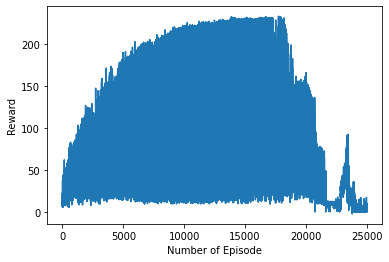

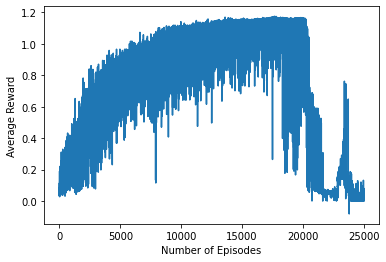

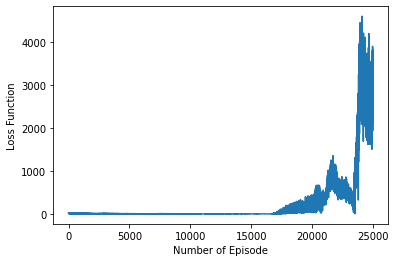

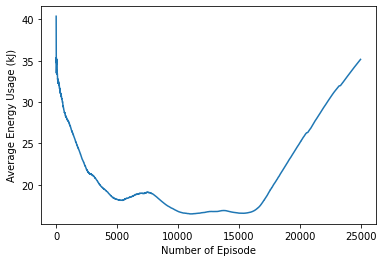

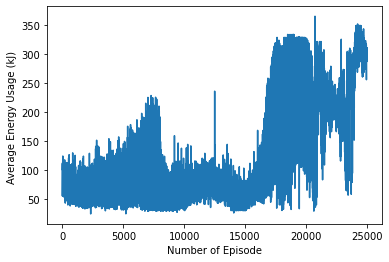

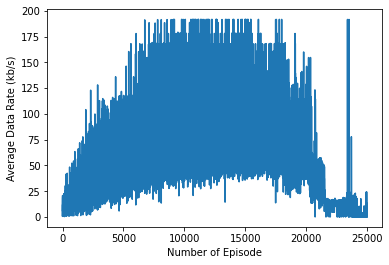

In [7]:
# reward visualization
fig1 = plt.figure()
#sns.set()
plt.plot(reward_per_episode)
plt.xlabel('Number of Episode')
plt.ylabel('Reward')

#norm=[]
#for k in reward_per_episode:
#    k=(k-min(reward_per_episode))/(max(reward_per_episode)-min(reward_per_episode))
#    norm.append(k)
#fig2 = plt.figure()
#sns.set()
#plt.plot(norm)
#plt.xlabel('Number of Episode')
#plt.ylabel('Normalized Reward')

fig2 = plt.figure()
#sns.set()
plt.plot(Avg_reward_per_episode)
plt.xlabel('Number of Episodes')
plt.ylabel('Average Reward')


# loss visualization
# convert loss values which are tensor values to a list of numpy array
losses_per_episode=[k.detach().numpy() for k in losses_per_episode if k is not None]
fig3=plt.figure()
#sns.set()
plt.plot(losses_per_episode)
plt.xlabel('Number of Episode')
plt.ylabel('Loss Function')

# energy usage visualization
fig4 = plt.figure()
#sns.set()
plt.plot(Avg_energy_training)
plt.xlabel('Number of Episode')
plt.ylabel('Average Energy Usage (kJ)')

fig5 = plt.figure()
#sns.set()
plt.plot(Avg_energy_per_episode)
plt.xlabel('Number of Episode')
plt.ylabel('Average Energy Usage (kJ) ')

# Data rate
fig6 = plt.figure()
#sns.set()
plt.plot(Avg_Rate_per_episode)
plt.xlabel('Number of Episode')
plt.ylabel('Average Data Rate (kb/s)')


plt.show()



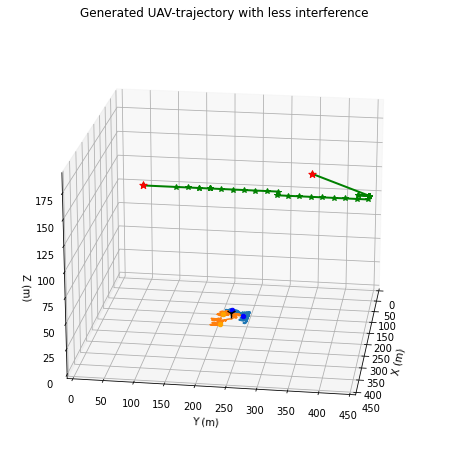

In [9]:
# uav trajectory for last episode
# the reason why uav is jumped to the terminal state is that I appened the destination to the 3 arrays, fix it!
#print(x_location)
#print(y_location)
#print(z_location)
#sns.set_style("whitegrid")
env.path_plot(x_location,y_location,z_location)

# saving results for plotting: lr=0.003
from numpy import savetxt
#savetxt('Average_reward_003.csv', Avg_reward, delimiter=',')
savetxt('reward_per_episode_003.csv', reward_per_episode, delimiter=',')
savetxt('Avg_reward_per_episode_003.csv', Avg_reward_per_episode, delimiter=',')
savetxt('losses_per_episode_003.csv', losses_per_episode, delimiter=',')
savetxt('Energy_per_episode_003.csv', Energy_per_episode, delimiter=',')
savetxt('Average_energy_003.csv', Avg_energy, delimiter=',')
#savetxt('Data_Rate_003.csv', Data_Rate_per_episode, delimiter=',')

In [11]:
# load parameters of saved dqn
Agent_DQN.main_network.load_state_dict(torch.load(FILE))

<All keys matched successfully>